# **R Laboratory Session 06**
### *Course:* Advanced Statistics for Physics Analysis, University of Padua, A.Y. 2021/22
### *Student:* Daniele Ninni
***
## **Table of Contents**
1) [**Exercise 1**](#sec1)
    - [1.A](#sec1.A)
    - [1.B](#sec1.B)
    - [1.C](#sec1.C)
    - [1.D](#sec1.D)
    - [1.E](#sec1.E)
2) [**Exercise 2**](#sec2)
    - [2.A](#sec2.A)
    - [2.B](#sec2.B)
3) [**Exercise 3**](#sec3)
    - [3.A](#sec3.A)
    - [3.B](#sec3.B)
    - [3.C](#sec3.C)
    - [3.D](#sec3.D)
    - [3.E](#sec3.E)
    - [3.F](#sec3.F)
    - [3.G](#sec3.G)
    - [3.H](#sec3.H)
4) [**Exercise 4**](#sec4)
5) [**Exercise 5**](#sec5)
6) [**Exercise 6**](#sec6)
***

In [1]:
# load packages
library(tidyverse)
library(rjags)

# set plot options (global)
theme_set(theme_bw(base_size=8))
options(
    repr.plot.width=7,  # plotting area width in inches  (default:   7)
    repr.plot.height=4, # plotting area height in inches (default:   7)
    repr.plot.res=300   # PPI for rasterization          (default: 120)
)

# set random seed for reproducibility
set.seed(5)

-- Attaching packages ------------------------------------------------------------------------------ tidyverse 1.3.1 --

v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.7     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts --------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Caricamento del pacchetto richiesto: coda

Linked to JAGS 4.2.0

Loaded modules: basemod,bugs



<a id='sec1'></a>
## **Exercise 1**

A well established and diffused method for detecting a disease in blood fails to detect the presence of the disease in $15\%$ of the patients that actually have the disease.

A young UniPD startup has developed an innovative method of screening. During the qualification phase, a random sample of $n = 75$ patients known to have the disease is screened using the new method.

<a id='sec1.A'></a>
### **1.A** What is the probability distribution for $y$, the number of times the new method fails to detect the disease?

Screening of the single sick patient is an example of a **Bernoulli trial**, i.e., a random experiment with exactly two possible outcomes, ***success*** with probability $p$ and ***failure*** with probability $q = 1-p$.

In the context of this exercise, the two possible outcomes can be defined as follows:

- ***success*** : the new method fails to detect the disease
- ***failure*** : the new method does NOT fail to detect the disease

Consequently, screening of the random sample of $n = 75$ sick patients is an example of a **Bernoulli process**, i.e., a sequence of $n$ independent identically distributed Bernoulli trials, each with a probability of success $p$.

The probability of exactly $k$ successes in a Bernoulli process is given by the **binomial distribution**:

$$ P(k \mid p,n) = \binom{n}{k} p^k q^{n-k} $$

Therefore, it is reasonable to assume that $y$, i.e. the number of times the new method fails to detect the disease, has a binomial distribution.

<a id='sec1.B'></a>
### **1.B** On the $n = 75$ patients sample, the new method fails to detect the disease in $y = 6$ cases. What is the frequentist estimator of the failure probability of the new method?

In the frequentist approach, an unbiased estimator for the probability of success $p$ given $n$ independent events with $y$ observed successes is:

$$ \hat p_F = \frac{y}{n} $$

Therefore, an unbiased estimator for the probability of the new method failing to detect the disease is:

$$ \hat p_F = \frac{6}{75} = 0.08 = 8 \% $$

<a id='sec1.C'></a>
### **1.C** Setup a Bayesian computation of the posterior probability, assuming a beta prior with mean value $0.15$ and standard deviation $0.14$. Plot the posterior distribution for $y$ and mark on the plot the mean value and variance

Bayes' theorem shows that:

$$ \text{posterior} \propto \text{likelihood} \cdot \text{prior} $$

In the context of this exercise, assume that:

- ***prior*** : beta distribution

$$ P(p \mid \mathcal{M}) = Beta(\mu = 0.15, \sigma = 0.14) $$

- ***likelihood*** : binomial distribution

$$ P(k \mid p,n,\mathcal{M}) = B(n = 75, p = \hat p_F = 0.08) $$

Recall that, in general, the beta prior is a **conjugate prior** for the binomial likelihood.

In other words, given a beta prior $Beta(\alpha_p, \beta_p)$ and a binomial likelihood $B(n,p)$, the prior and posterior are **conjugate distributions**.

Quantitatively, if $y$ is the number of successes, the posterior is a beta distribution $Beta(\alpha, \beta)$ with the following parameters:

$$ \alpha = \alpha_p + y $$

$$ \beta = \beta_p + n - y $$

In the context of this exercise:

- $\alpha_p = \left( \frac{\mu (1 - \mu)}{\sigma^2} - 1 \right) \mu$
- $\beta_p = \left( \frac{\mu (1 - \mu)}{\sigma^2} - 1 \right) (1 - \mu)$
- $n = 75$
- $y = 6$

Therefore, the ***posterior*** distribution for $y$ is the following beta distribution:

$$ (p \mid k,n,\mathcal{M}) = Beta(\alpha = \alpha_p + y, \beta = \beta_p + n - y) $$

In [2]:
# function that, given the mean value and standard deviation of a beta distribution, computes the corresponding 'alpha' parameter
to_alpha <- function(mean, sd) {((mean * (1 - mean) / (sd^2)) - 1) * mean}

# function that, given the mean value and standard deviation of a beta distribution, computes the corresponding 'beta' parameter
to_beta  <- function(mean, sd) {((mean * (1 - mean) / (sd^2)) - 1) * (1 - mean)}

In [3]:
# function that, given a beta prior and a binomial likelihood, performs Bayesian inference
beta_posterior <- function(p=seq(from=0, to=1, length=10^3), prior.mean=0, prior.sd=0, prior.alpha=to_alpha(prior.mean, prior.sd), prior.beta=to_beta(prior.mean, prior.sd), n_trials, n_successes, level=.95, colour='black') {

    # posterior
    alpha     <- prior.alpha + n_successes
    beta      <- prior.beta + n_trials - n_successes
    mean      <- alpha / (alpha + beta)
    sd        <- sqrt(alpha * beta / (((alpha + beta)^2) * (alpha + beta + 1)))
    mask      <- (p > (mean - sd) & p < (mean + sd))
    posterior <- dbeta(x=p, shape1=alpha, shape2=beta)

    # Bayesian estimator for "p"
    bayes_est <- p[which.max(posterior)]

    # credible interval
    lower <- qbeta(p=(1-level)/2, shape1=alpha, shape2=beta)
    upper <- qbeta(p=(1+level)/2, shape1=alpha, shape2=beta)

    # posterior plot
    plot <- ggplot() +
                geom_line(aes(x=p, y=posterior), colour=colour) +
                geom_vline(xintercept=mean, colour=colour, linetype='dashed') +
                geom_area(aes(x=p[mask], y=posterior[mask]), fill=colour, alpha=.1) +
                scale_x_continuous(n.breaks=21) +
                scale_y_continuous(n.breaks=12) +
                ylab('PDF') +
                ggtitle(str_glue('posterior = Beta(alpha={round(alpha, 4)}, beta={round(beta, 4)}, mean={round(mean, 4)}, sd={round(sd, 4)})'))

    return(list('alpha'=alpha, 'beta'=beta, 'bayes_est'=bayes_est, 'cred_int'=c(lower, upper), 'plot'=plot))

}

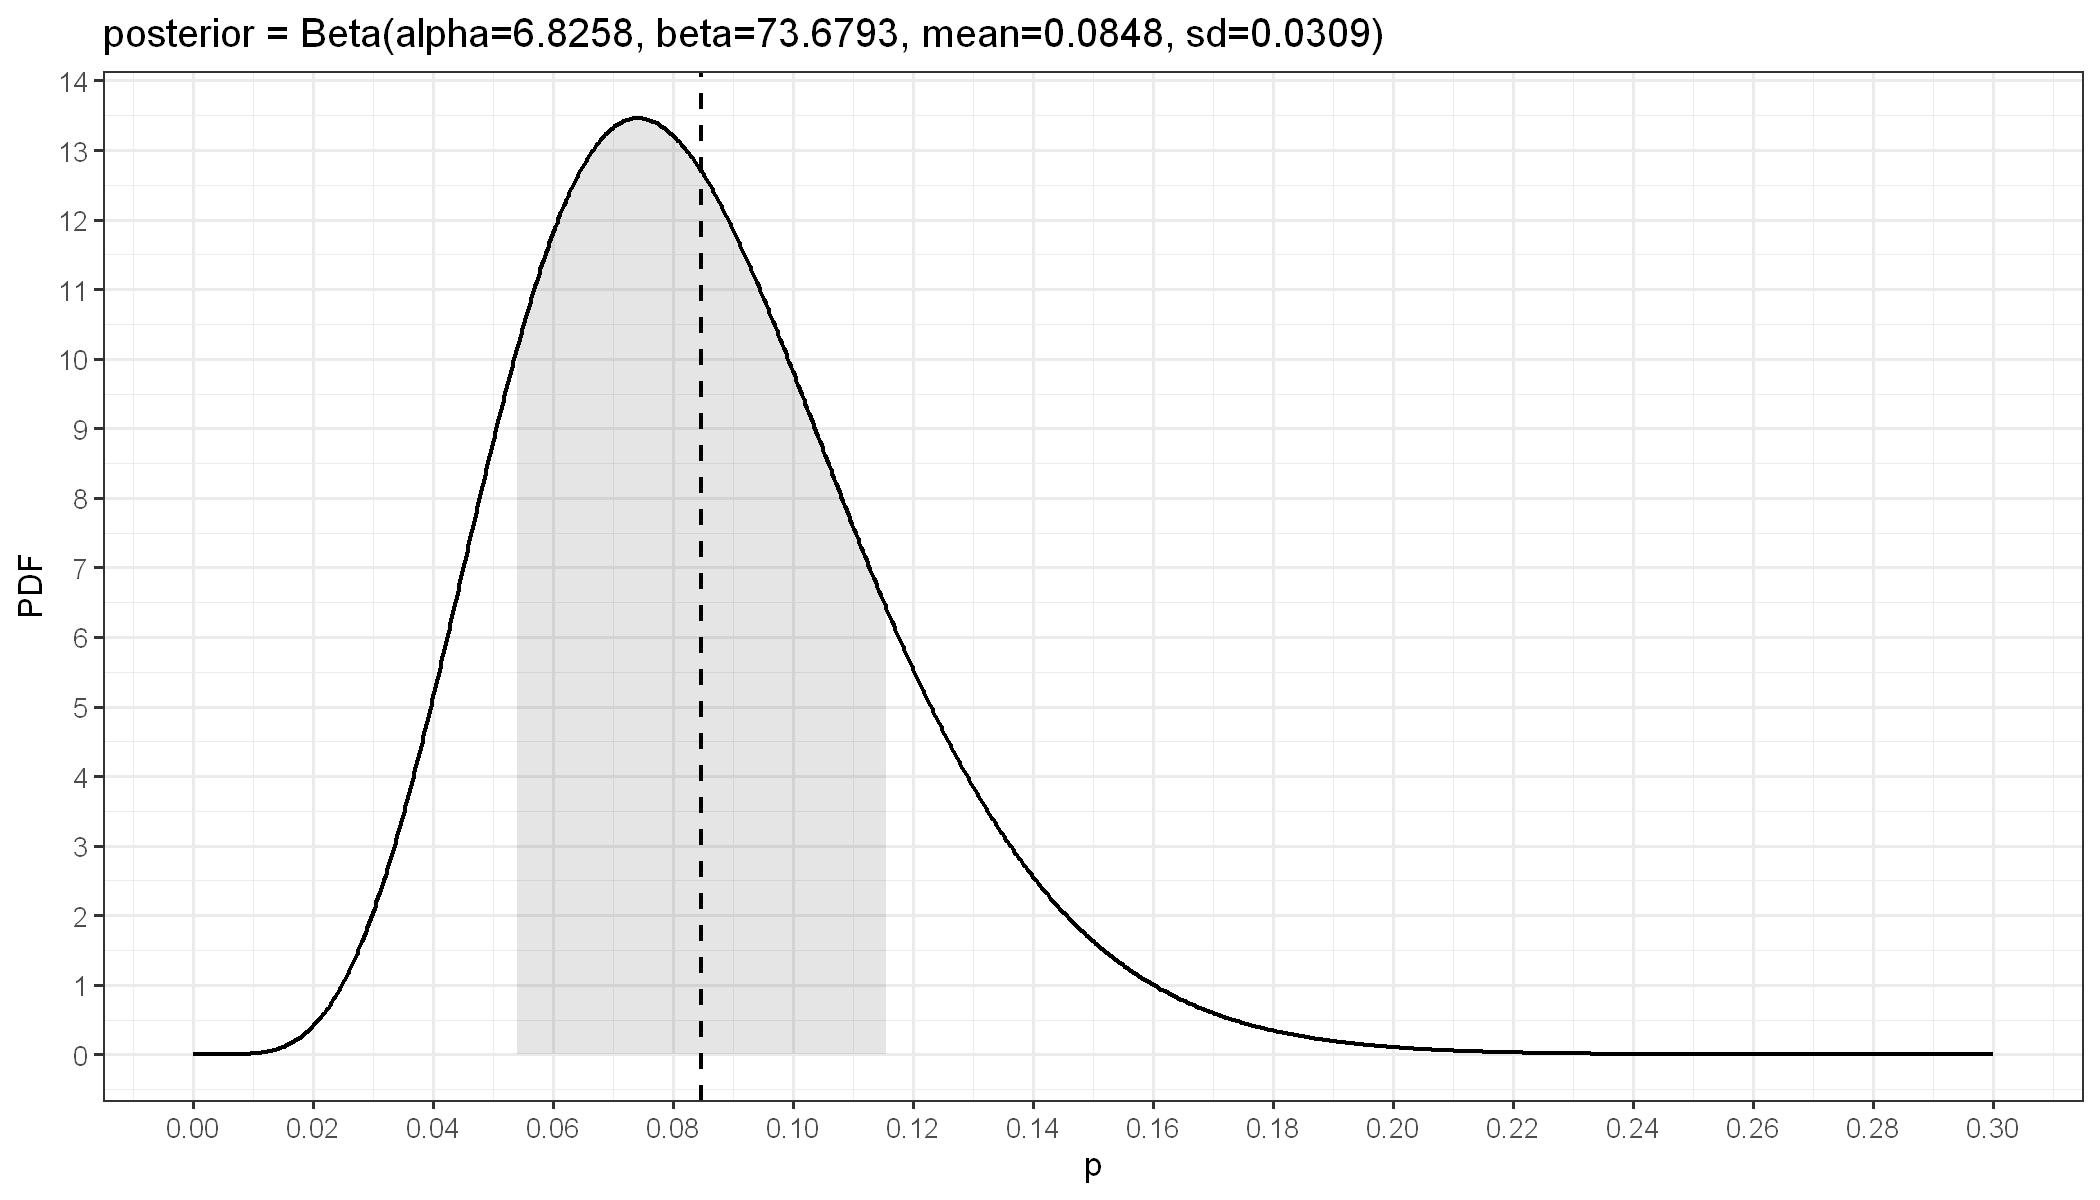

In [4]:
# screening outcome
n <- 75
y <- 6

# probability "p"
p.min    <- 0
p.max    <- .3
p.length <- 10^3
p        <- seq(from=p.min, to=p.max, length=p.length)

# prior
prior.mean <- .15
prior.sd   <- .14

# posterior
posterior <- beta_posterior(p, prior.mean, prior.sd, n_trials=n, n_successes=y, colour='black')

# posterior plot
posterior$plot

<a id='sec1.D'></a>
### **1.D** Perform a hypothesis test assuming that, if the probability of failing to detect the disease in sick patients is greater or equal than $15\%$, the new test is no better than the traditional method. Test the sample at a $5\%$ level of significance in the Bayesian way

- $p =$ probability of the new method failing to detect the disease

- $p_0 =$ probability of the traditional method failing to detect the disease $= 15 \%$

- null hypothesis:

  $H_0 : p \geq p_0$

- alternative hypothesis:

  $H_1 : p < p_0$

- significance level:

  $\alpha = 5 \%$

***

**Bayesian one-sided hypothesis test:**

1) Calculate the posterior probability of the null hypothesis $P(H_0 \mid y)$ by integrating the posterior $g(p \mid y)$ over the required region:

$$ P(H_0 : p \leq p_0 \mid y) = \int_{0}^{p_0} g(p \mid y) dp $$

$$ P(H_0 : p \geq p_0 \mid y) = \int_{p_0}^{1} g(p \mid y) dp $$

2) Reject $H_0$, in favor of $H_1$, if and only if

$$ P(H_0 \mid y) < \alpha $$

***

**Bayesian two-sided hypothesis test:**

1) Calculate a $100(1 - \alpha) \%$ credible interval for $p$

2) Reject $H_0$, in favor of $H_1$, if and only if $p_0$ is outside the credible interval itself

***

In [5]:
# function that performs a Bayesian hypothesis test
HT.bayesian <- function(p_0, posterior.alpha, posterior.beta, significance, alternative) {

    cat('Significance level:', significance)

    if (alternative == 'two.sided') {

        level <- 1 - significance
        lower <- qbeta(p=(1-level)/2, shape1=posterior.alpha, shape2=posterior.beta)
        upper <- qbeta(p=(1+level)/2, shape1=posterior.alpha, shape2=posterior.beta)
        cat(str_glue('\n\n{100*level}% credible interval for "p": [{round(lower, 4)}, {round(upper, 4)}]'))

        cat('\nIs the null hypothesis rejected?', ifelse((p_0 < lower | p_0 > upper), 'YES', 'NO'))

    } else {

        null.posterior <- pbeta(q=p_0, shape1=posterior.alpha, shape2=posterior.beta)
        if (alternative == 'less') {null.posterior <- 1 - null.posterior}
        cat('\nPosterior probability of the null hypothesis:', null.posterior)

        cat('\nIs the null hypothesis rejected?', ifelse(null.posterior < significance, 'YES', 'NO'))
        
    }

}

In [6]:
p_0          <- .15
significance <- .05    # significance level
alternative  <- 'less' # alternative hypothesis

In [7]:
# Bayesian hypothesis test
HT.bayesian(p_0, posterior$alpha, posterior$beta, significance, alternative)

Significance level: 0.05
Posterior probability of the null hypothesis: 0.03127933
Is the null hypothesis rejected? YES

<a id='sec1.E'></a>
### **1.E** Perform the same hypothesis test in the classical frequentist way

***

**Frequentist hypothesis test:**

1) Calculate the $\texttt{p-value}$, i.e. the probability, under $H_0$, of sampling a test statistic at least as extreme as that which was observed

2) Reject $H_0$, in favor of $H_1$, if and only if

$$ \texttt{p-value} < \alpha $$

***

In [8]:
# function that performs a frequentist hypothesis test
HT.frequentist <- function(p_0, n_successes, n_trials, significance, alternative) {

    test <- binom.test(x=n_successes, n=n_trials, p=p_0, alternative=alternative, conf.level=1-significance)
    print(test)

    cat('Is the null hypothesis rejected?', ifelse(test$p.value < significance, 'YES', 'NO'))

}

In [9]:
# frequentist hypothesis test
HT.frequentist(p_0, y, n, significance, alternative)


	Exact binomial test

data:  n_successes and n_trials
number of successes = 6, number of trials = 75, p-value = 0.05435
alternative hypothesis: true probability of success is less than 0.15
95 percent confidence interval:
 0.0000000 0.1517971
sample estimates:
probability of success 
                  0.08 

Is the null hypothesis rejected? NO

<a id='sec2'></a>
## **Exercise 2**

Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution.

Considering the following two sets of observations taken over a fixed large time interval in two different corps:

| $y \ \text{death soldiers}$ | $0$ | $1$ | $2$ | $3$ | $4$ | $\geq 5$ |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| $n_1 \ \text{observations}$ | $109$ | $65$ | $22$ | $3$ | $1$ | $0$ |
| $n_2 \ \text{observations}$ | $144$ | $91$ | $32$ | $11$ | $2$ | $0$ |

<a id='sec2.A'></a>
### **2.A** Assuming a uniform prior, compute and plot the posterior distribution for $\lambda$, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the $95\%$ credible interval

Bayes' theorem shows that:

$$ \text{posterior} \propto \text{likelihood} \cdot \text{prior} $$

In the context of this exercise, assume that:

- ***prior*** : gamma distribution

$$ P(p \mid \mathcal{M}) = Gamma(\alpha = \alpha_p, \lambda = \lambda_p) $$

- ***likelihood*** : Poisson distribution

$$ P(k \mid p,n,\mathcal{M}) = Pois(\lambda) $$

Recall that, in general, the gamma prior is a **conjugate prior** for the Poisson likelihood.

In other words, given a gamma prior $Gamma(\alpha_p, \lambda_p)$ and a Poisson likelihood $Pois(\lambda)$, the prior and posterior are **conjugate distributions**.

Quantitatively, given a set of $n$ observations $\{y_i\}$, the posterior is a gamma distribution $Gamma(\alpha, \lambda)$ with the following parameters:

$$ \alpha = \alpha_p + \sum_{i=1}^{n} y_i $$

$$ \lambda = \lambda_p + n $$

Therefore, the ***posterior*** distribution for $\lambda$ is the following gamma distribution:

$$ (p \mid k,n,\mathcal{M}) = Gamma(\alpha = \alpha_p + \sum y_i, \lambda = \lambda_p + n) $$

In [10]:
# function that, given a gamma prior and a Poisson likelihood, performs Bayesian inference
gamma_posterior <- function(x=seq(from=0, to=5, length=10^3), prior.alpha=0, prior.lambda=0, y, observations, level=.95, colour=c('red', 'blue')) {

    posterior.tbl <- tibble(x)
    stats.list    <- list()
    cred_int.list <- list()

    for (i in names(observations)) {

        n <- observations[[i]]

        # posterior
        alpha         <- prior.alpha + sum(y * n)
        lambda        <- prior.lambda + sum(n)
        posterior     <- dgamma(x=x, shape=alpha, rate=lambda)
        posterior.tbl <- posterior.tbl %>% mutate(!!str_glue('{i}.posterior') := posterior)
        
        # statistical quantities evaluated analytically
        stats.list[str_glue('{i}.mean.analytical')]     <- alpha / lambda                         # mean
        stats.list[str_glue('{i}.median.analytical')]   <- qgamma(p=.5, shape=alpha, rate=lambda) # median
        stats.list[str_glue('{i}.variance.analytical')] <- alpha / (lambda^2)                     # variance

        # statistical quantities evaluated numerically
        d.x <- (max(x) - min(x)) / length(x)
        stats.list[str_glue('{i}.mean.numerical')]     <- sum(x * posterior) * d.x                                    # mean
        stats.list[str_glue('{i}.median.numerical')]   <- x[which.min(abs(cumsum(posterior)*d.x - .5))]               # median
        stats.list[str_glue('{i}.variance.numerical')] <- (sum((x^2)*posterior) * d.x) - ((sum(x*posterior) * d.x)^2) # variance

        # credible interval
        cred_int.list[str_glue('{i}.lower')] <- qgamma(p=(1-level)/2, shape=alpha, rate=lambda)
        cred_int.list[str_glue('{i}.upper')] <- qgamma(p=(1+level)/2, shape=alpha, rate=lambda)

    }

    posterior.tbl <- posterior.tbl %>%
                        pivot_longer(!x, names_to='set', values_to='posterior') %>%
                        mutate(set=str_sub(set, start=1, end=2))

    stats.tbl     <- as_tibble(stats.list) %>%
                        pivot_longer(everything(), names_to=c('set', 'value_type', 'evaluation_type'), names_sep='\\.', values_to='value') %>%
                        pivot_wider(names_from=value_type, values_from=value)

    cred_int.tbl  <- as_tibble(cred_int.list) %>%
                        pivot_longer(everything(), names_to=c('set', 'end_type'), names_sep='\\.', values_to='value') %>%
                        pivot_wider(names_from=end_type, values_from=value)  

    # posteriors plot
    plot <- ggplot(data=posterior.tbl, aes(x=x, y=posterior, colour=set)) +
                geom_line() +
                scale_color_manual(values=colour) +
                scale_x_continuous(n.breaks=13) +
                scale_y_continuous(n.breaks=9) +
                xlab('lambda') +
                ggtitle(str_glue('prior = Gamma(alpha={round(prior.alpha, 4)}, lambda={round(prior.lambda, 4)})')) +
                theme(
                    legend.background = element_rect(colour='black'),
                    legend.margin     = margin(t=-3.5, r=3, b=.5, l=.5),
                    legend.title      = element_blank(),
                    legend.position   = c(.9, .8))

    return(list('stats'=stats.tbl, 'cred_int'=cred_int.tbl, 'plot'=plot))

}

In [11]:
# death soldiers
y <- c(0, 1, 2, 3, 4)

# observations
n1           <- c(109, 65, 22, 3,  1)
n2           <- c(144, 91, 32, 11, 2)
observations <- list('n1'=n1, 'n2'=n2)

# parameter "lambda" (= death rate over measurement time)
lambda.min    <- 0
lambda.max    <- 1.2
lambda.length <- 10^3
lambda        <- seq(from=lambda.min, to=lambda.max, length=lambda.length)

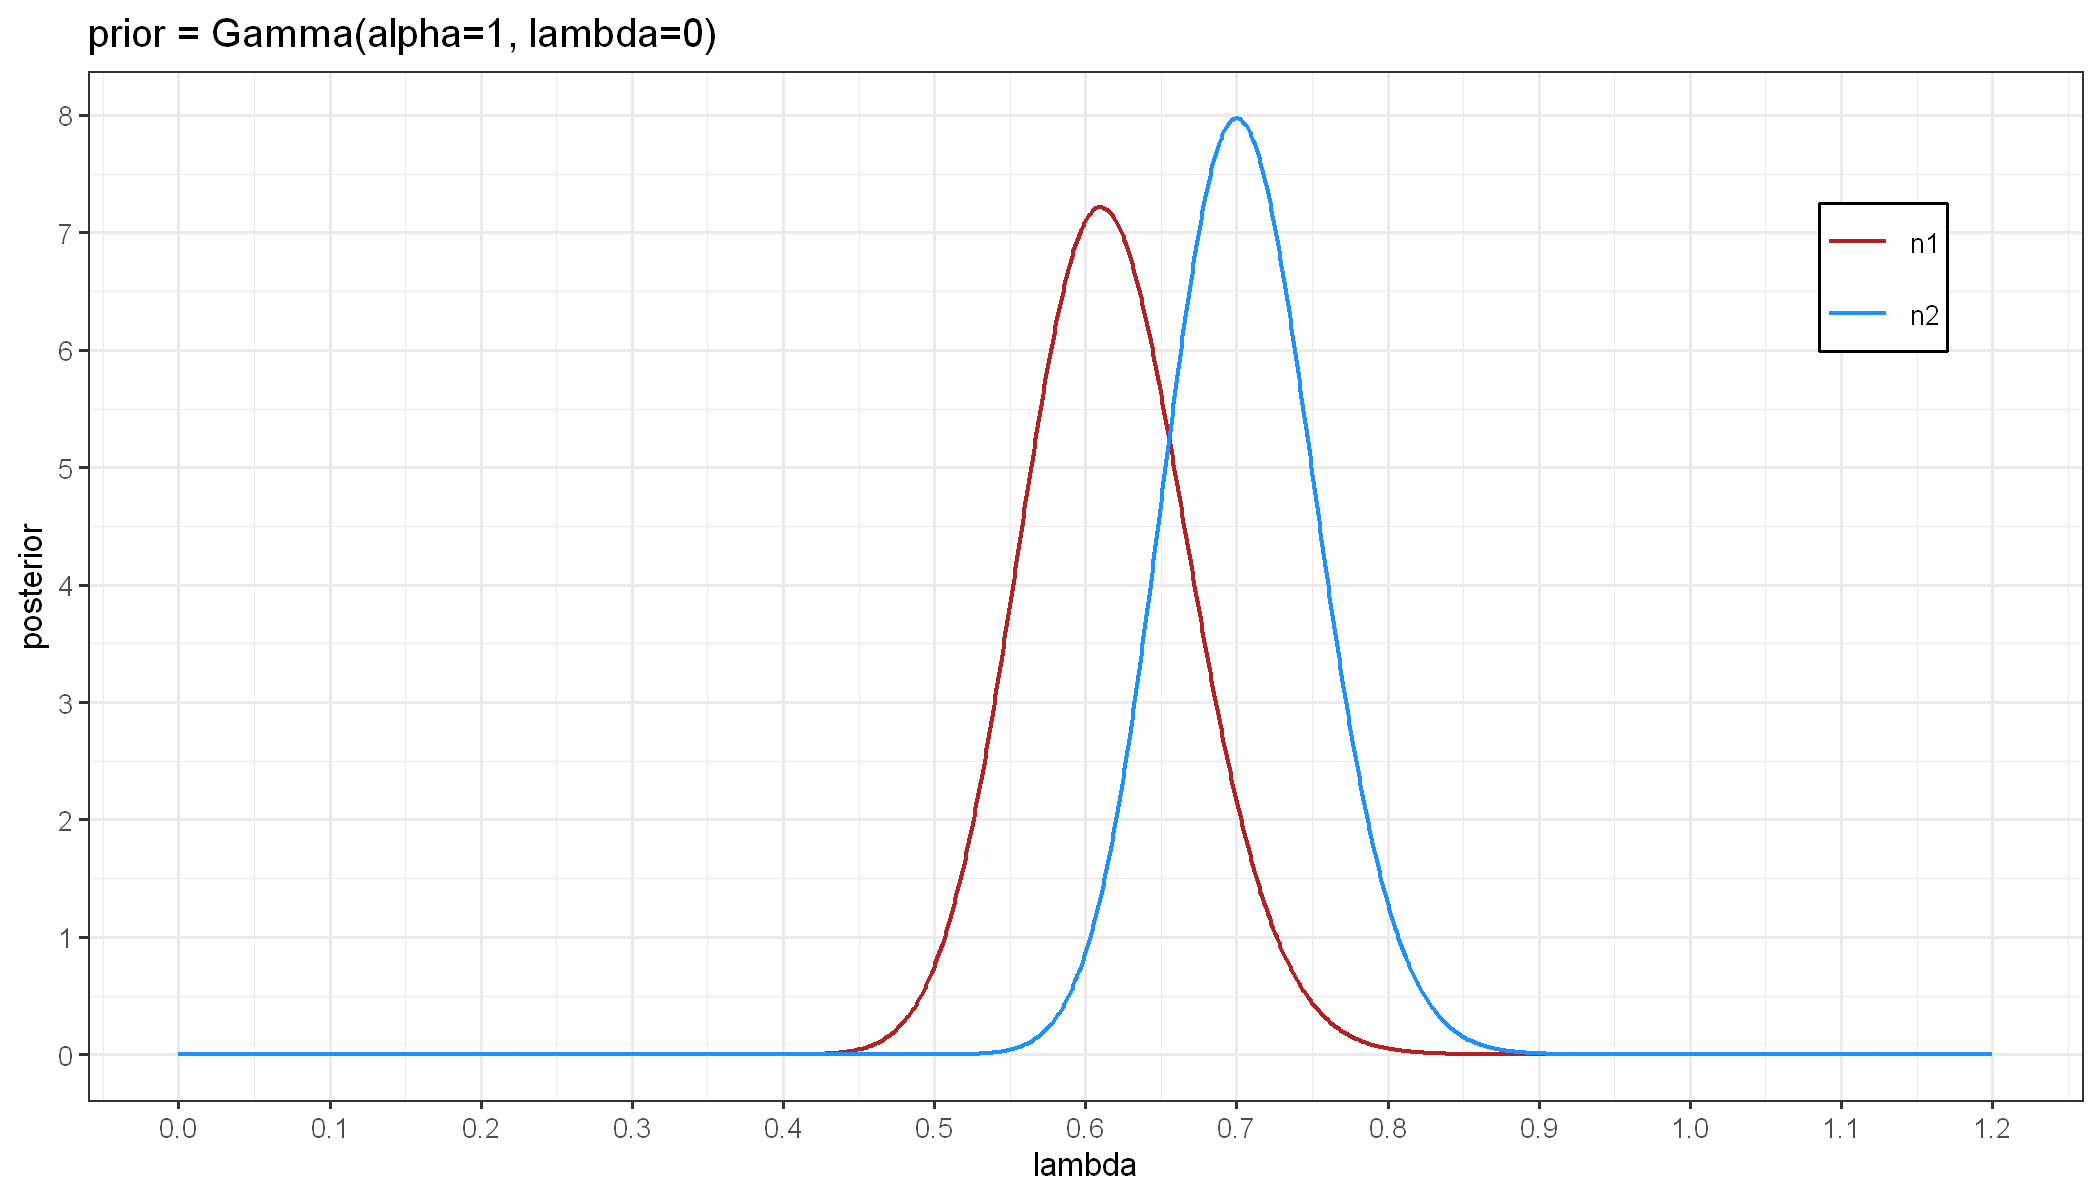

In [12]:
# uniform prior
prior_unif.alpha  <- 1
prior_unif.lambda <- 0

# posteriors (uniform prior)
posterior_unif <- gamma_posterior(lambda, prior_unif.alpha, prior_unif.lambda, y, observations, level=.95, colour=c('firebrick', 'dodgerblue'))

# posteriors plot (uniform prior)
posterior_unif$plot

In [13]:
# statistical quantities (uniform prior)
posterior_unif$stats

set,evaluation_type,mean,median,variance
<chr>,<chr>,<dbl>,<dbl>,<dbl>
n1,analytical,0.6150000,0.6133341,0.003075000
n1,numerical,0.6143850,0.6126126,0.003449772
n2,analytical,0.7035714,0.7023813,0.002512755
n2,numerical,0.7028679,0.7015015,0.003004760


In [14]:
# credible interval (uniform prior)
posterior_unif$cred_int

set,lower,upper
<chr>,<dbl>,<dbl>
n1,0.5111251,0.7283408
n2,0.6087487,0.8051570


<a id='sec2.B'></a>
### **2.B** Assuming now a Jeffreys prior,

### $$ g(\lambda) \propto 1 / \sqrt \lambda \ ,\ \text{with} \ \lambda > 0 $$

### compute and plot the posterior distribution for $\lambda$, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the $95\%$ credible interval

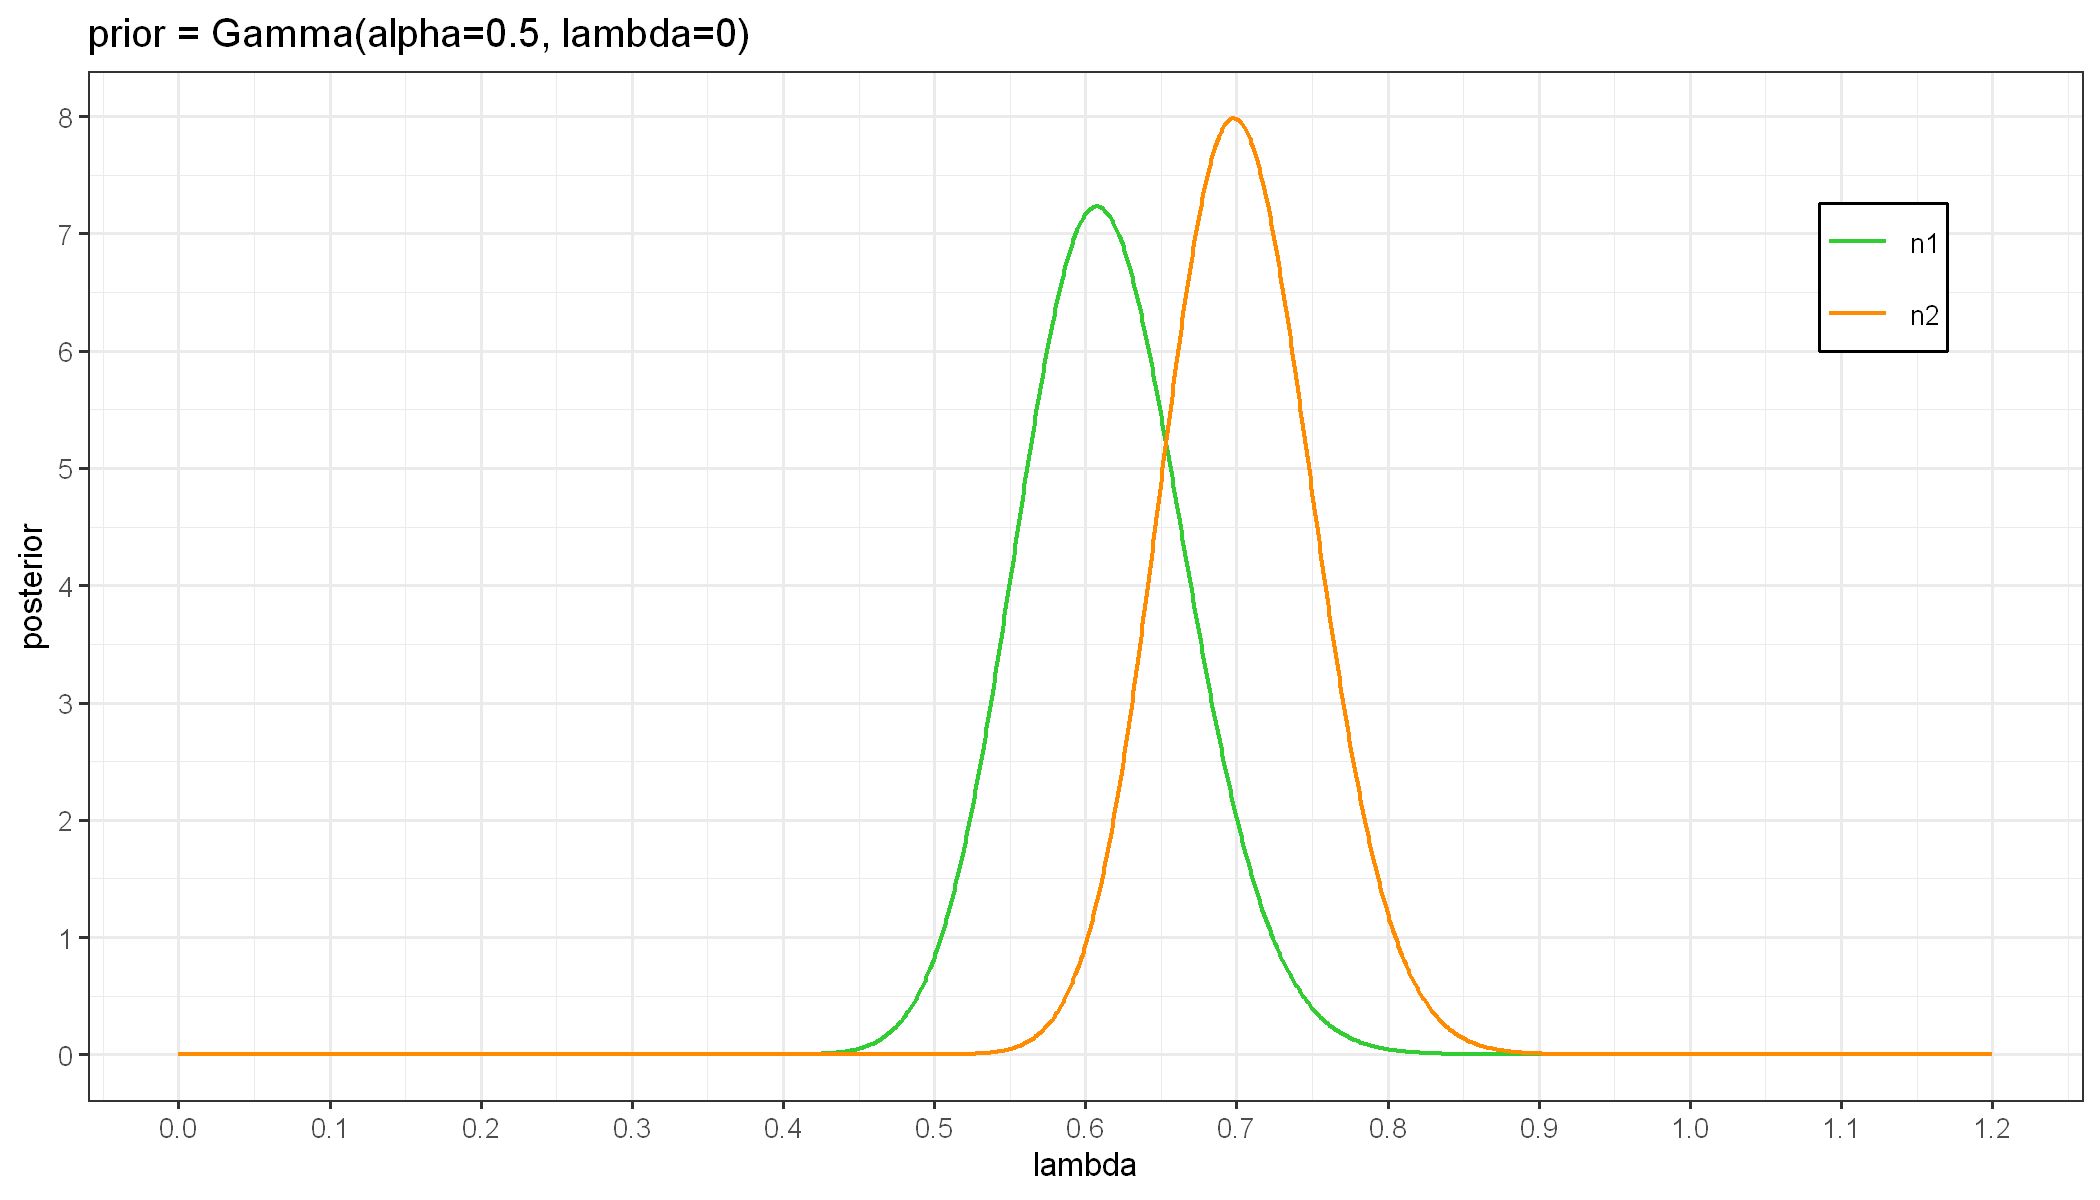

In [15]:
# Jeffreys prior
prior_jeffreys.alpha  <- 1 / 2
prior_jeffreys.lambda <- 0

# posteriors (Jeffreys prior)
posterior_jeffreys <- gamma_posterior(lambda, prior_jeffreys.alpha, prior_jeffreys.lambda, y, observations, level=.95, colour=c('limegreen', 'darkorange'))

# posteriors plot (Jeffreys prior)
posterior_jeffreys$plot

In [16]:
# statistical quantities (Jeffreys prior)
posterior_jeffreys$stats

set,evaluation_type,mean,median,variance
<chr>,<chr>,<dbl>,<dbl>,<dbl>
n1,analytical,0.6125000,0.6108341,0.003062500
n1,numerical,0.6118875,0.6102102,0.003434219
n2,analytical,0.7017857,0.7005956,0.002506378
n2,numerical,0.7010839,0.7003003,0.002995882


In [17]:
# credible interval (Jeffreys prior)
posterior_jeffreys$cred_int

set,lower,upper
<chr>,<dbl>,<dbl>
n1,0.5088464,0.7256196
n2,0.6070878,0.8032465


<a id='sec3'></a>
## **Exercise 3**

In a study on water quality of streams, a high level of bacteria $X$ was defined as a level greater than 100 per 100 ml of stream water. $n = 116$ samples were taken from streams having a high environmental impact on pandas. Out of these, $y = 11$ had a high level of bacteria $X$.

Indicating with $p$ the probability that a sample of water taken from the stream has a high level of bacteria $X$:

<a id='sec3.A'></a>
### **3.A** Find the frequentist estimator for $p$

***

The analysis of the single water sample is an example of a **Bernoulli trial**, i.e., a random experiment with exactly two possible outcomes, ***success*** with probability $p$ and ***failure*** with probability $q = 1-p$.

In the context of this exercise, the two possible outcomes can be defined as follows:

- ***success*** : the water sample has a high level of bacteria $X$
- ***failure*** : the water sample does NOT have a high level of bacteria $X$

Consequently, the analysis of the $n = 116$ water samples is an example of a **Bernoulli process**, i.e., a sequence of $n$ independent identically distributed Bernoulli trials, each with a probability of success $p$.

The probability of exactly $k$ successes in a Bernoulli process is given by the **binomial distribution**:

$$ P(k \mid p,n) = \binom{n}{k} p^k q^{n-k} $$

Therefore, it is reasonable to assume that $y$, i.e. the number of water samples with a high level of bacteria $X$, has a binomial distribution.

***

In the frequentist approach, an unbiased estimator for the probability of success $p$ given $n$ independent events with $y$ observed successes is:

$$ \hat p_F = \frac{y}{n} $$

Therefore, an unbiased estimator for the probability that a water sample has a high level of bacteria $X$ is:

$$ \hat p_F = \frac{11}{116} \approx 9.48 \% $$

<a id='sec3.B'></a>
### **3.B** Using a $\texttt{Beta}(1,10)$ prior for $p$, calculate and plot the posterior distribution $P(p \mid y)$

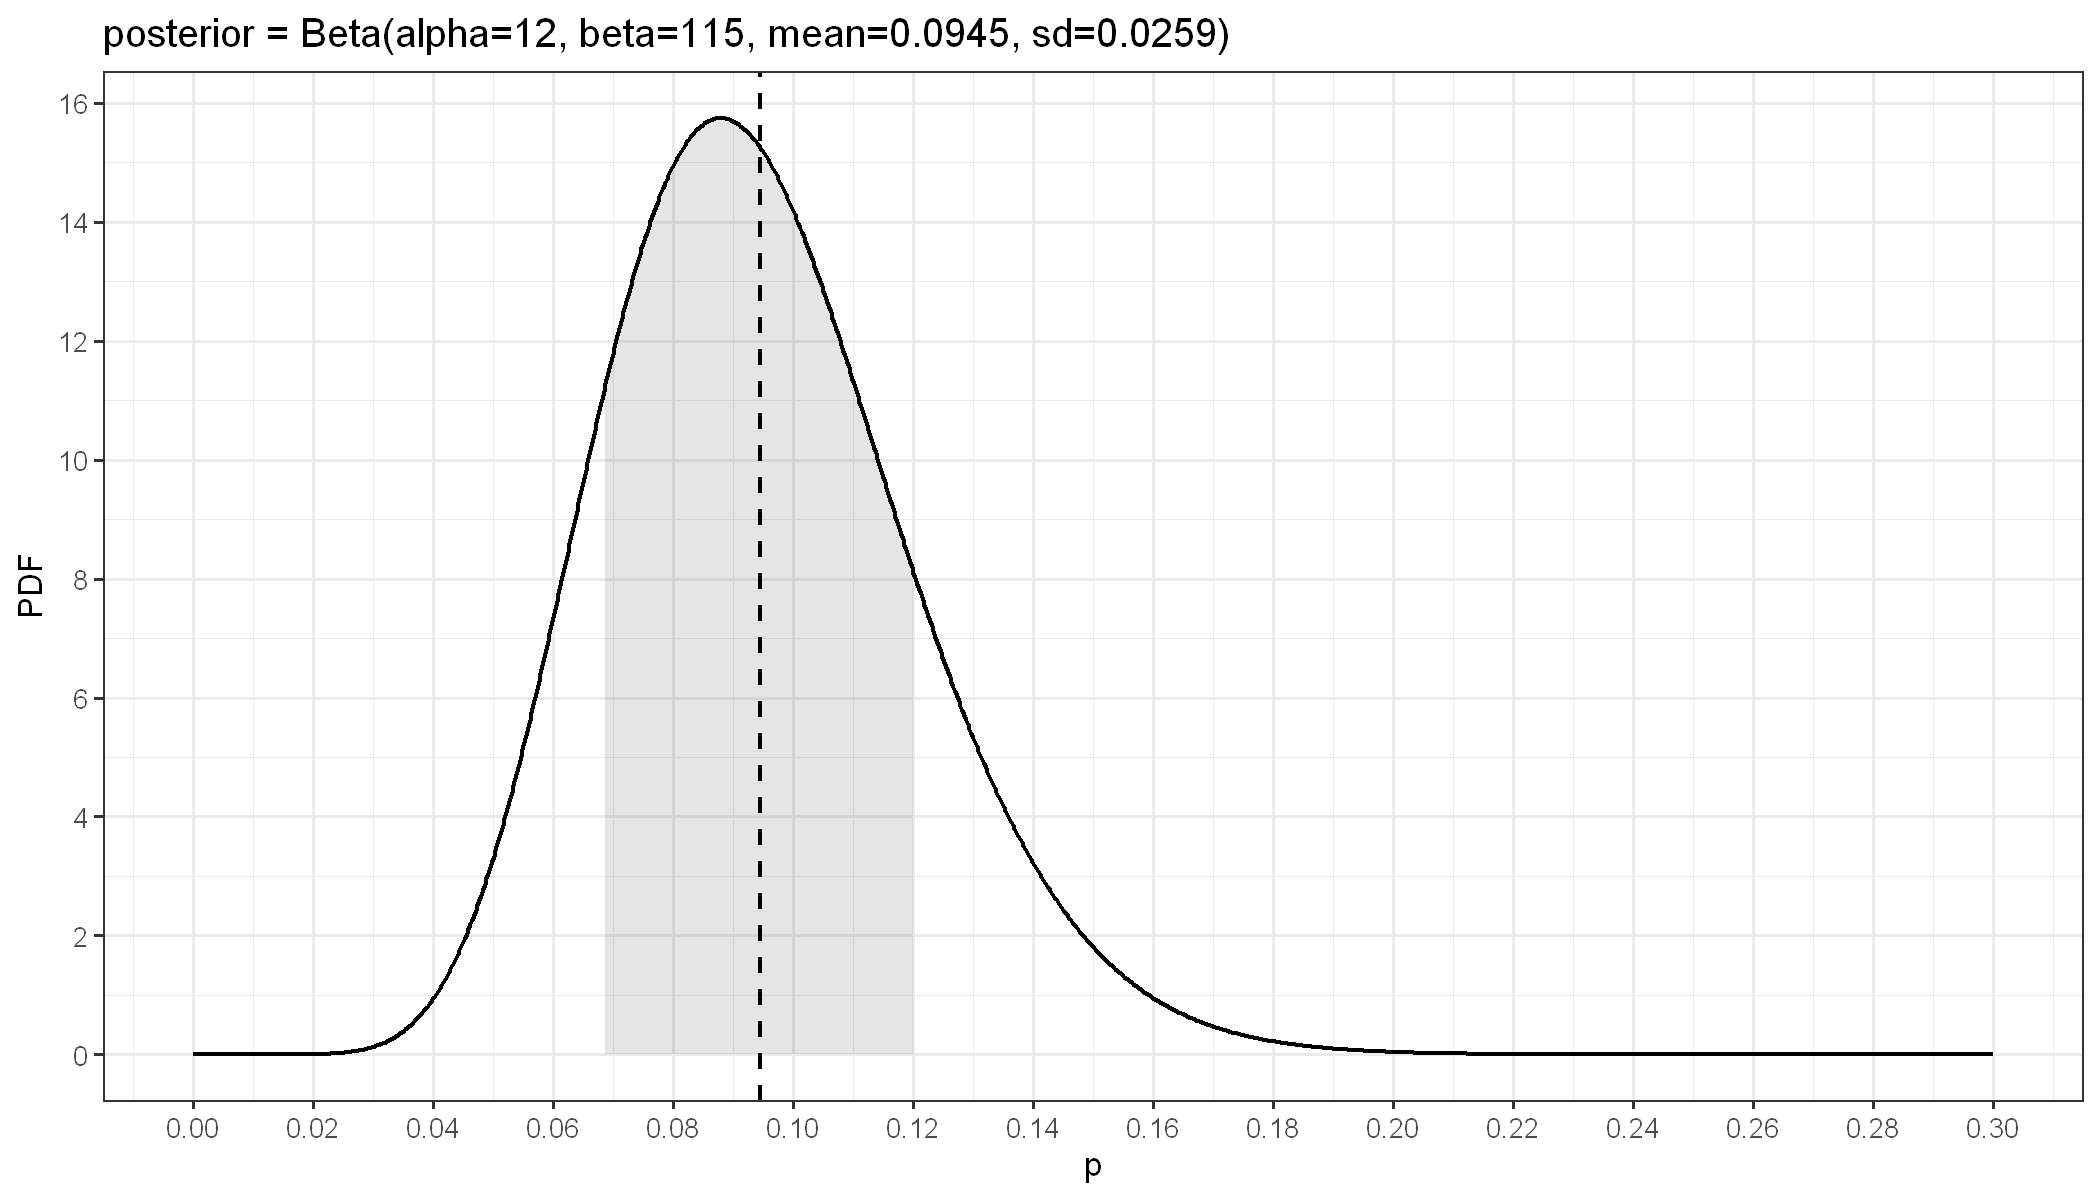

In [18]:
# analysis outcome
n <- 116
y <- 11

# probability "p"
p.min    <- 0
p.max    <- .3
p.length <- 10^3
p        <- seq(from=p.min, to=p.max, length=p.length)

# prior
prior.alpha <- 1
prior.beta  <- 10

# posterior
posterior <- beta_posterior(p, prior.alpha=prior.alpha, prior.beta=prior.beta, n_trials=n, n_successes=y, level=.95, colour='black')

# posterior plot
posterior$plot

<a id='sec3.C'></a>
### **3.C** Find the Bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credible interval

The posterior mean and variance are reported in the posterior plot above.

In [19]:
# Bayesian estimator for "p"
cat('Bayesian estimator for "p":', round(100*posterior$bayes_est, 2), '%')

Bayesian estimator for "p": 8.8 %

In [20]:
# credible interval
cat(str_glue('95% credible interval for "p": [{round(posterior$cred_int[1], 4)}, {round(posterior$cred_int[2], 4)}]'))

95% credible interval for "p": [0.0502, 0.1508]

<a id='sec3.D'></a>
### **3.D** Test the hypothesis

### $$ H_0 : p = 0.1 \ \text{versus} \ H_1 : p \neq 0.1 $$

### at $5\%$ level of significance with both the frequentist and Bayesian approach

In [21]:
p_0          <- .1
significance <- .05         # significance level
alternative  <- 'two.sided' # alternative hypothesis

In [22]:
# Bayesian hypothesis test
HT.bayesian(p_0, posterior$alpha, posterior$beta, significance, alternative)

Significance level: 0.05
95% credible interval for "p": [0.0502, 0.1508]
Is the null hypothesis rejected? NO

In [23]:
# frequentist hypothesis test
HT.frequentist(p_0, y, n, significance, alternative)


	Exact binomial test

data:  n_successes and n_trials
number of successes = 11, number of trials = 116, p-value = 1
alternative hypothesis: true probability of success is not equal to 0.1
95 percent confidence interval:
 0.04829409 0.16333954
sample estimates:
probability of success 
            0.09482759 

Is the null hypothesis rejected? NO

A new measurement, performed one month later on $n = 165$ water samples, gives $y = 9$ high level of bacteria $X$.

<a id='sec3.E'></a>
### **3.E** Find the frequentist estimator for $p$

In the frequentist approach, an unbiased estimator for the probability of success $p$ given $n$ independent events with $y$ observed successes is:

$$ \hat p_F = \frac{y}{n} $$

Therefore, an unbiased estimator for the probability that a water sample has a high level of bacteria $X$ is:

$$ \hat p_F = \frac{9}{165} \approx 5.45 \% $$

<a id='sec3.F'></a>
### **3.F** Calculate and plot the posterior distribution $P(p \mid y)$, assuming both a $\texttt{Beta}(1,10)$ and the posterior probability of the older measurement as prior for $p$

In [24]:
# analysis outcome
n <- 165
y <- 9

# probability "p"
p.min    <- 0
p.max    <- .3
p.length <- 10^3
p        <- seq(from=p.min, to=p.max, length=p.length)

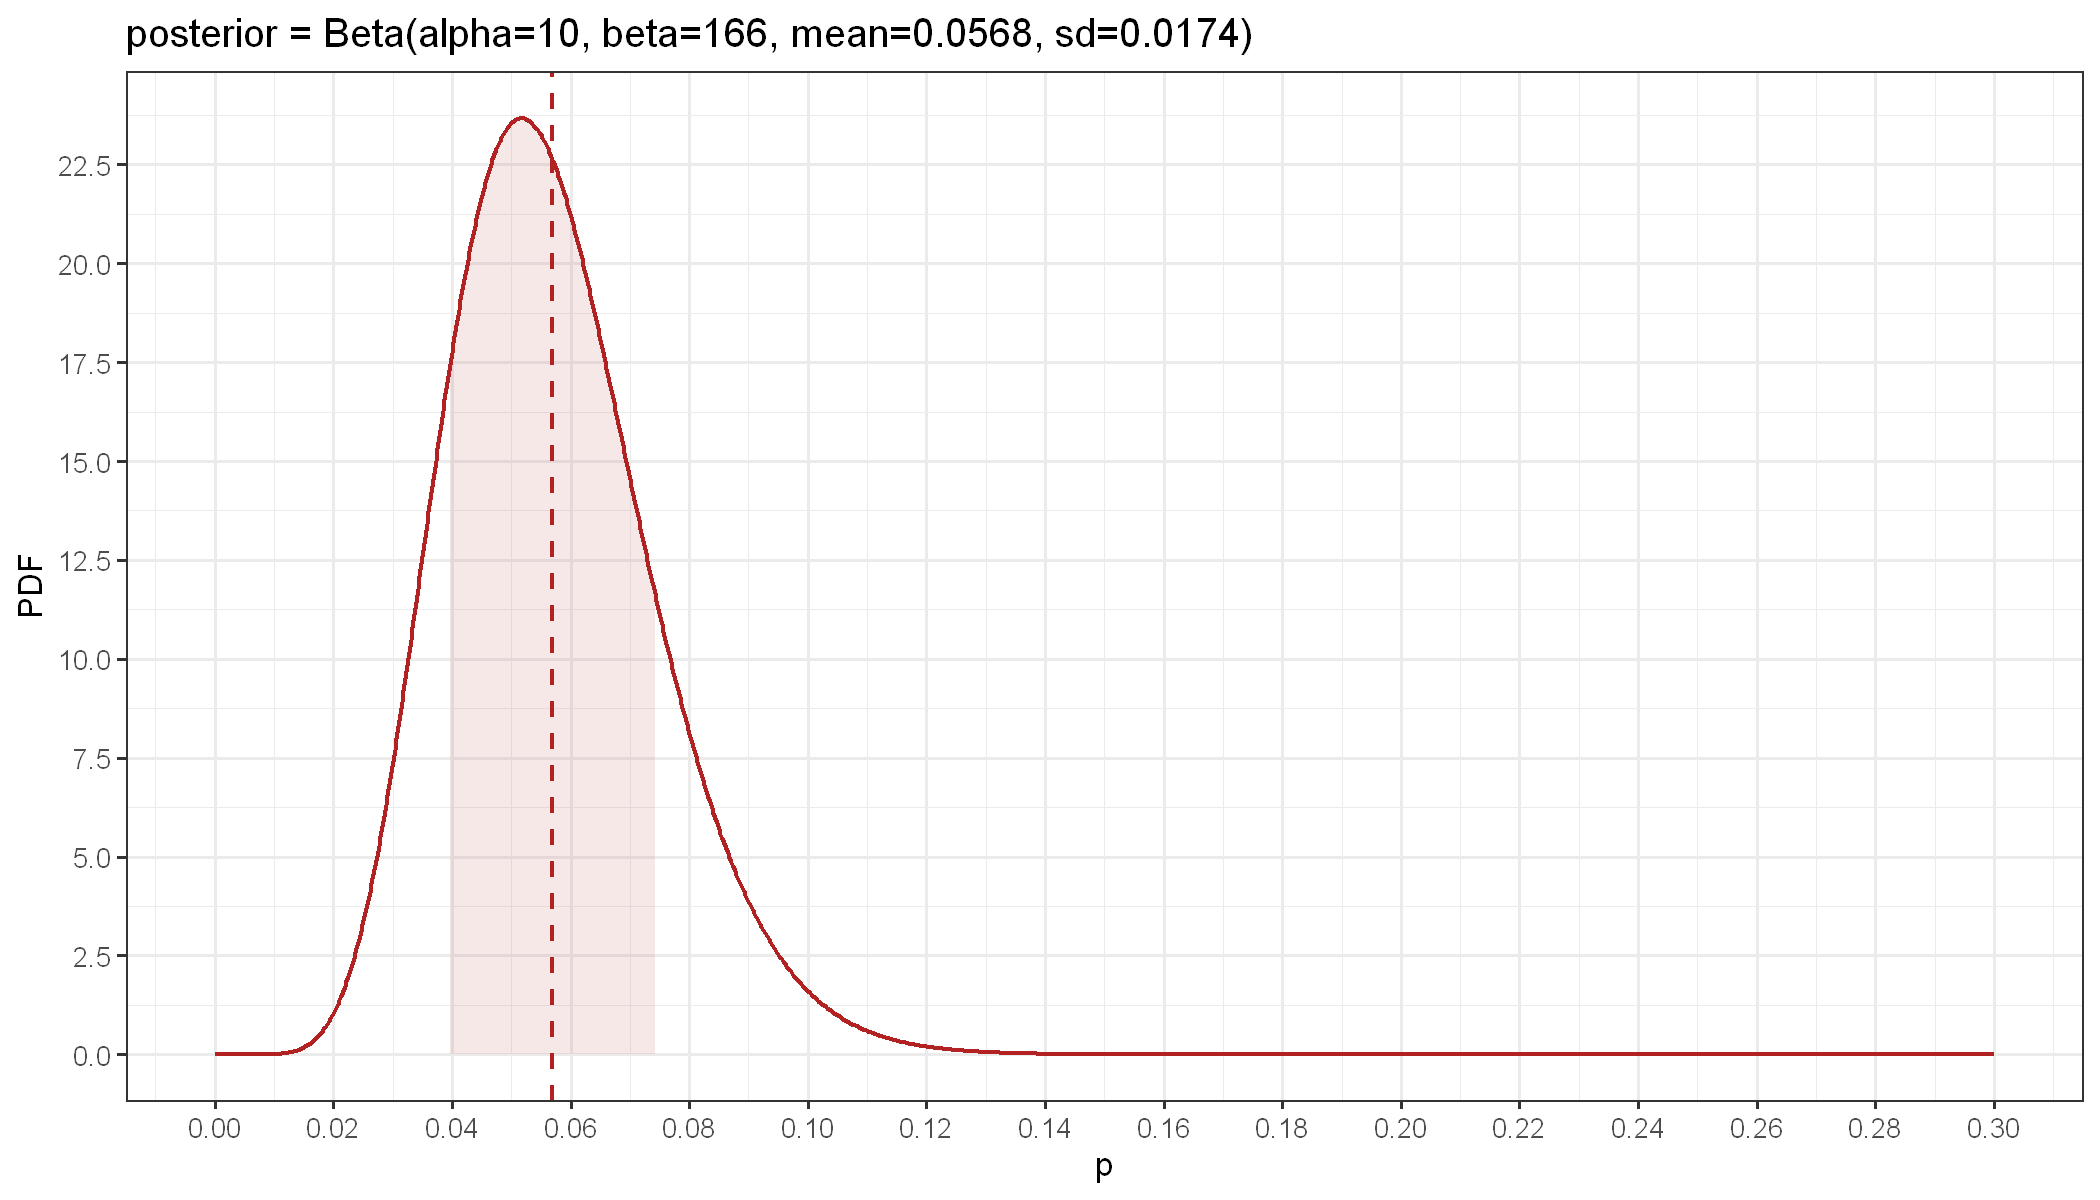

In [25]:
# beta prior
prior_beta.alpha <- 1
prior_beta.beta  <- 10

# posterior (beta prior)
posterior_beta <- beta_posterior(p, prior.alpha=prior_beta.alpha, prior.beta=prior_beta.beta, n_trials=n, n_successes=y, level=.95, colour='firebrick')

# posterior plot (beta prior)
posterior_beta$plot

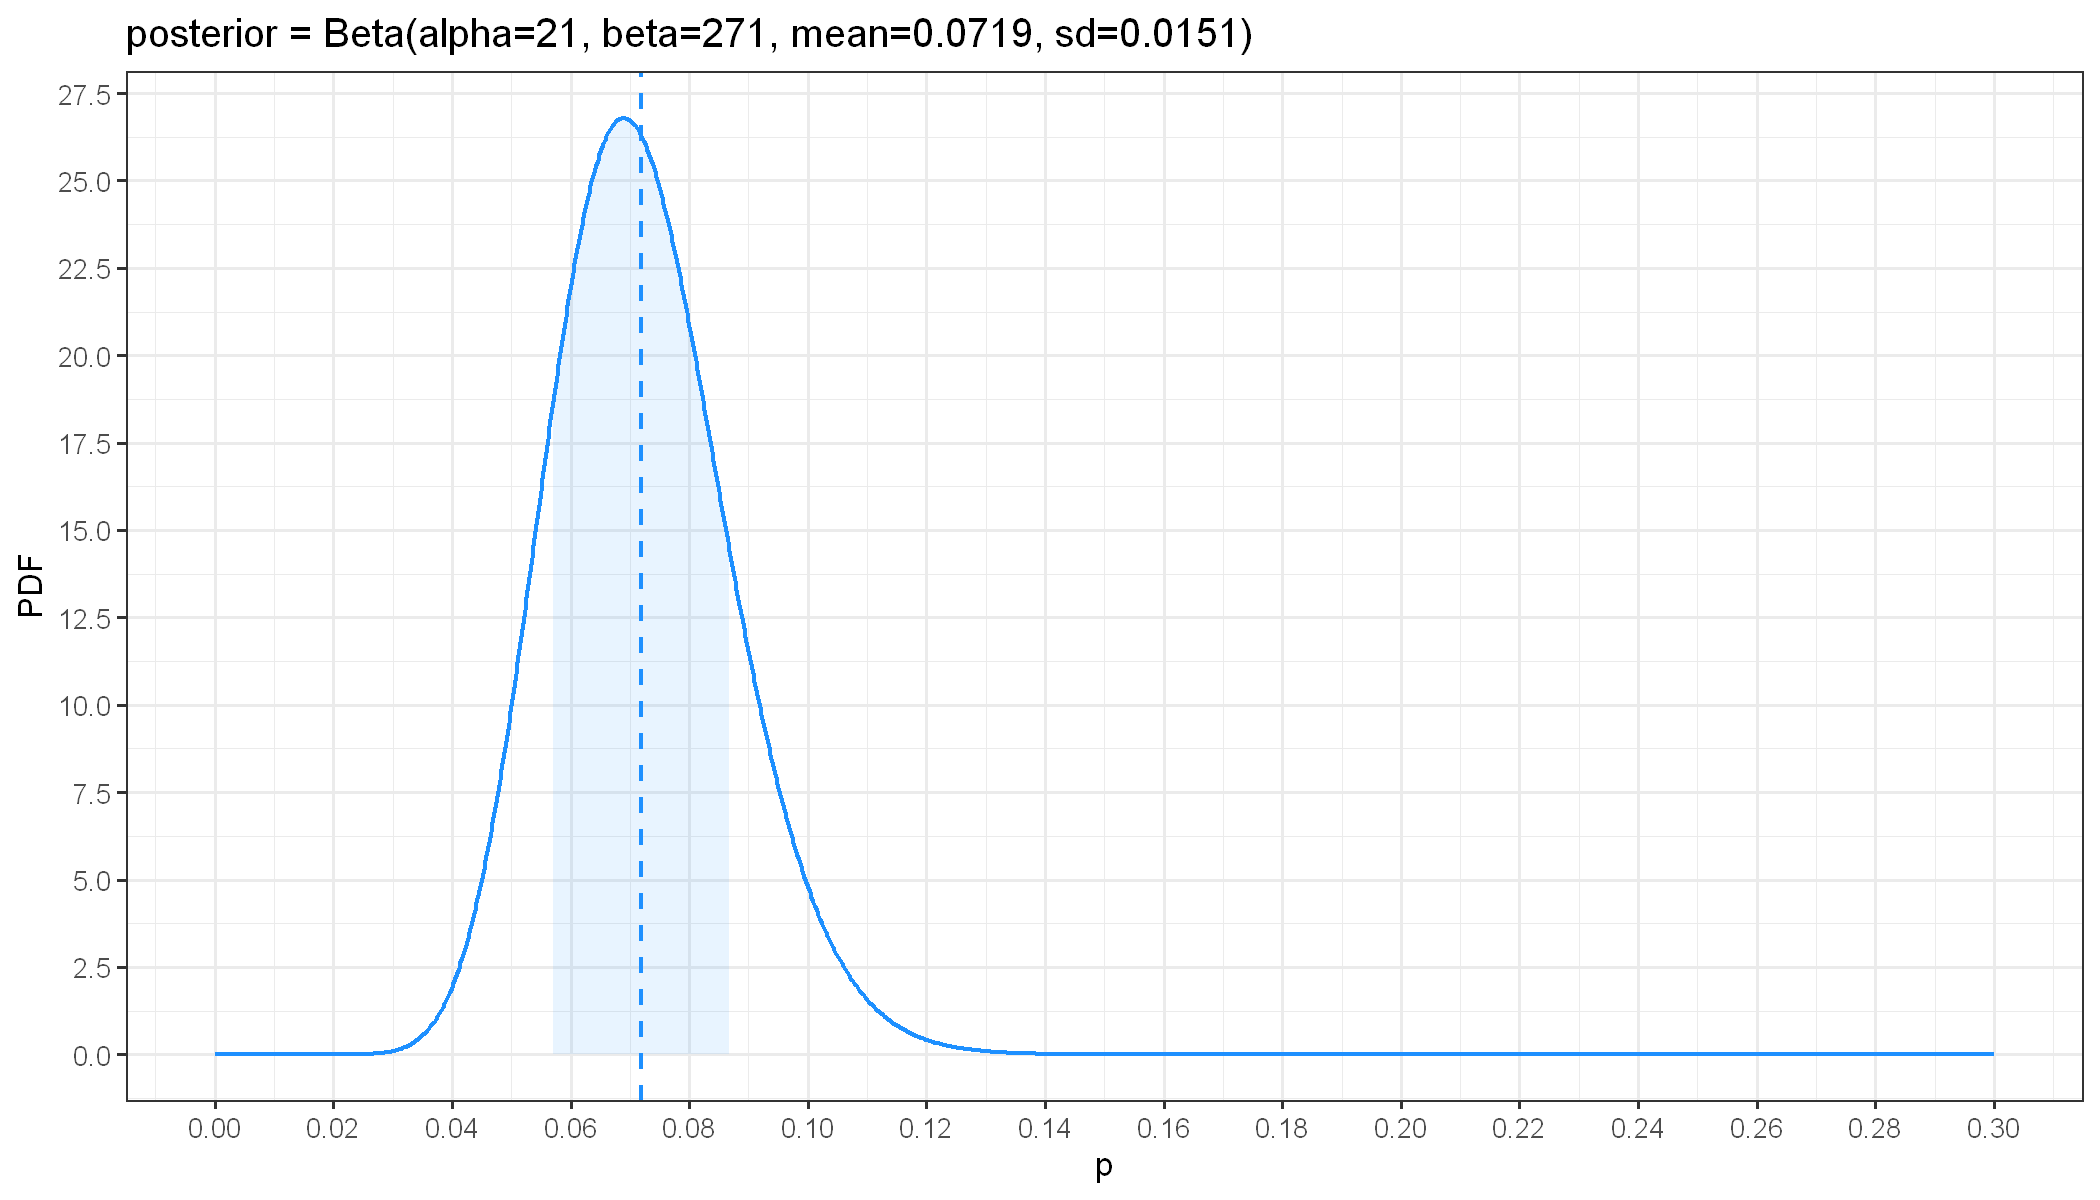

In [26]:
# old posterior as prior
prior_old.alpha <- posterior$alpha
prior_old.beta  <- posterior$beta

# posterior (old posterior as prior)
posterior_old <- beta_posterior(p, prior.alpha=prior_old.alpha, prior.beta=prior_old.beta, n_trials=n, n_successes=y, level=.95, colour='dodgerblue')

# posterior plot (old posterior as prior)
posterior_old$plot

<a id='sec3.G'></a>
### **3.G** Find the Bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credible interval

The posterior mean and variance are reported in the posterior plots above.

In [27]:
cat('+----------+\n')
cat('|BETA PRIOR|\n')
cat('+----------+\n')

# Bayesian estimator for "p"
cat('Bayesian estimator for "p":', round(100*posterior_beta$bayes_est, 2), '%')

# credible interval
cat(str_glue('\n\n95% credible interval for "p": [{round(posterior_beta$cred_int[1], 4)}, {round(posterior_beta$cred_int[2], 4)}]'))

+----------+
|BETA PRIOR|
+----------+
Bayesian estimator for "p": 5.17 %
95% credible interval for "p": [0.0277, 0.0954]

In [28]:
cat('+----------------------+\n')
cat('|OLD POSTERIOR AS PRIOR|\n')
cat('+----------------------+\n')

# Bayesian estimator for "p"
cat('Bayesian estimator for "p":', round(100*posterior_old$bayes_est, 2), '%')

# credible interval
cat(str_glue('\n\n95% credible interval for "p": [{round(posterior_old$cred_int[1], 4)}, {round(posterior_old$cred_int[2], 4)}]'))

+----------------------+
|OLD POSTERIOR AS PRIOR|
+----------------------+
Bayesian estimator for "p": 6.91 %
95% credible interval for "p": [0.0452, 0.1042]

<a id='sec3.H'></a>
### **3.H** Test the hypothesis

### $$ H_0 : p = 0.1 \ \text{versus} \ H_1 : p \neq 0.1 $$

### at $5\%$ level of significance with both the frequentist and Bayesian approach

In [29]:
p_0          <- .1
significance <- .05         # significance level
alternative  <- 'two.sided' # alternative hypothesis

In [30]:
# frequentist hypothesis test
HT.frequentist(p_0, y, n, significance, alternative)


	Exact binomial test

data:  n_successes and n_trials
number of successes = 9, number of trials = 165, p-value = 0.05112
alternative hypothesis: true probability of success is not equal to 0.1
95 percent confidence interval:
 0.02524192 0.10101679
sample estimates:
probability of success 
            0.05454545 

Is the null hypothesis rejected? NO

In [31]:
cat('+----------+\n')
cat('|BETA PRIOR|\n')
cat('+----------+\n')

# Bayesian hypothesis test (beta prior)
HT.bayesian(p_0, posterior_beta$alpha, posterior_beta$beta, significance, alternative)

+----------+
|BETA PRIOR|
+----------+
Significance level: 0.05
95% credible interval for "p": [0.0277, 0.0954]
Is the null hypothesis rejected? YES

In [32]:
cat('+----------------------+\n')
cat('|OLD POSTERIOR AS PRIOR|\n')
cat('+----------------------+\n')

# Bayesian hypothesis test (old posterior as prior)
HT.bayesian(p_0, posterior_old$alpha, posterior_old$beta, significance, alternative)

+----------------------+
|OLD POSTERIOR AS PRIOR|
+----------------------+
Significance level: 0.05
95% credible interval for "p": [0.0452, 0.1042]
Is the null hypothesis rejected? NO

<a id='sec4'></a>
## **Exercise 4**

- ### Analyze the data of **Exercise 1** using a MCMC with JAGS (solve only **1.C**)

In [33]:
# function that, given a beta prior and a binomial likelihood, performs Bayesian inference using JAGS MCMC
jags_mcmc.beta <- function(prior.mean=0, prior.sd=0, prior.alpha=to_alpha(prior.mean, prior.sd), prior.beta=to_beta(prior.mean, prior.sd), n_trials, n_successes, n_predictions=10, burn_in=10^3, n_iterations=10^4, thinning=1, colour='black', seed=5) {

    # set random seed for reproducibility
    set.seed(seed)

    # Bernoulli sequence
    X <- c(rep(1, n_successes), rep(0, n_trials - n_successes)) |> sample()

    # likelihood
    likelihood <- 'for (i in 1:length(X)) {X[i] ~ dbern(p);}'

    # prior
    prior <- 'p ~ dbeta(prior.alpha, prior.beta);'

    # predictions
    predictions <- 'y ~ dbin(p, n_predictions);'

    # list containing the data for the model
    data <- list('X'=X, 'prior.alpha'=prior.alpha, 'prior.beta'=prior.beta, 'n_predictions'=n_predictions)

    # BUGS model
    bugs_model <- paste('model {', likelihood, prior, predictions, '}') |> textConnection()

    # JAGS model
    jags_model <- jags.model(file=bugs_model, data=data, inits=list('.RNG.name'='base::Mersenne-Twister', '.RNG.seed'=seed))

    # update the JAGS model ("burn-in" period)
    update(object=jags_model, n.iter=burn_in)

    # generate posterior samples
    mcmc <- coda.samples(model=jags_model, variable.names=c('p', 'y'), n.iter=n_iterations, thin=thinning)
    print(summary(mcmc))
    
    # MCMC plot
    options(repr.plot.width=10, repr.plot.height=5)
    par(mar=c(2.5, 1.5, 1.5, .5), mgp=c(1.5, .5, 0), oma=c(0, 0, 0, 0), xpd=NA)
    plot(mcmc, col=colour)

    # correlation matrix
    corr_matrix <- mcmc |> as.mcmc() |> cor()

    # correlation plot
    corr_plot <- ggplot(data = mcmc |> as.mcmc() |> as_tibble(), aes(x=p, y=y)) +
                    geom_point(colour=colour, shape='plus') +
                    scale_x_continuous(n.breaks=11, limits=c(0, 1)) +
                    scale_y_continuous(n.breaks=11)

    return(list('corr_matrix'=corr_matrix, 'corr_plot'=corr_plot))

}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 75
   Unobserved stochastic nodes: 2
   Total graph size: 80

Initializing model


Iterations = 1001:101000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

     Mean      SD  Naive SE Time-series SE
p 0.08465 0.03081 9.743e-05      9.743e-05
y 8.45487 4.14516 1.311e-02      1.311e-02

2. Quantiles for each variable:

     2.5%    25%    50%     75%  97.5%
p 0.03472 0.0622 0.0812  0.1035  0.154
y 2.00000 5.0000 8.0000 11.0000 18.000



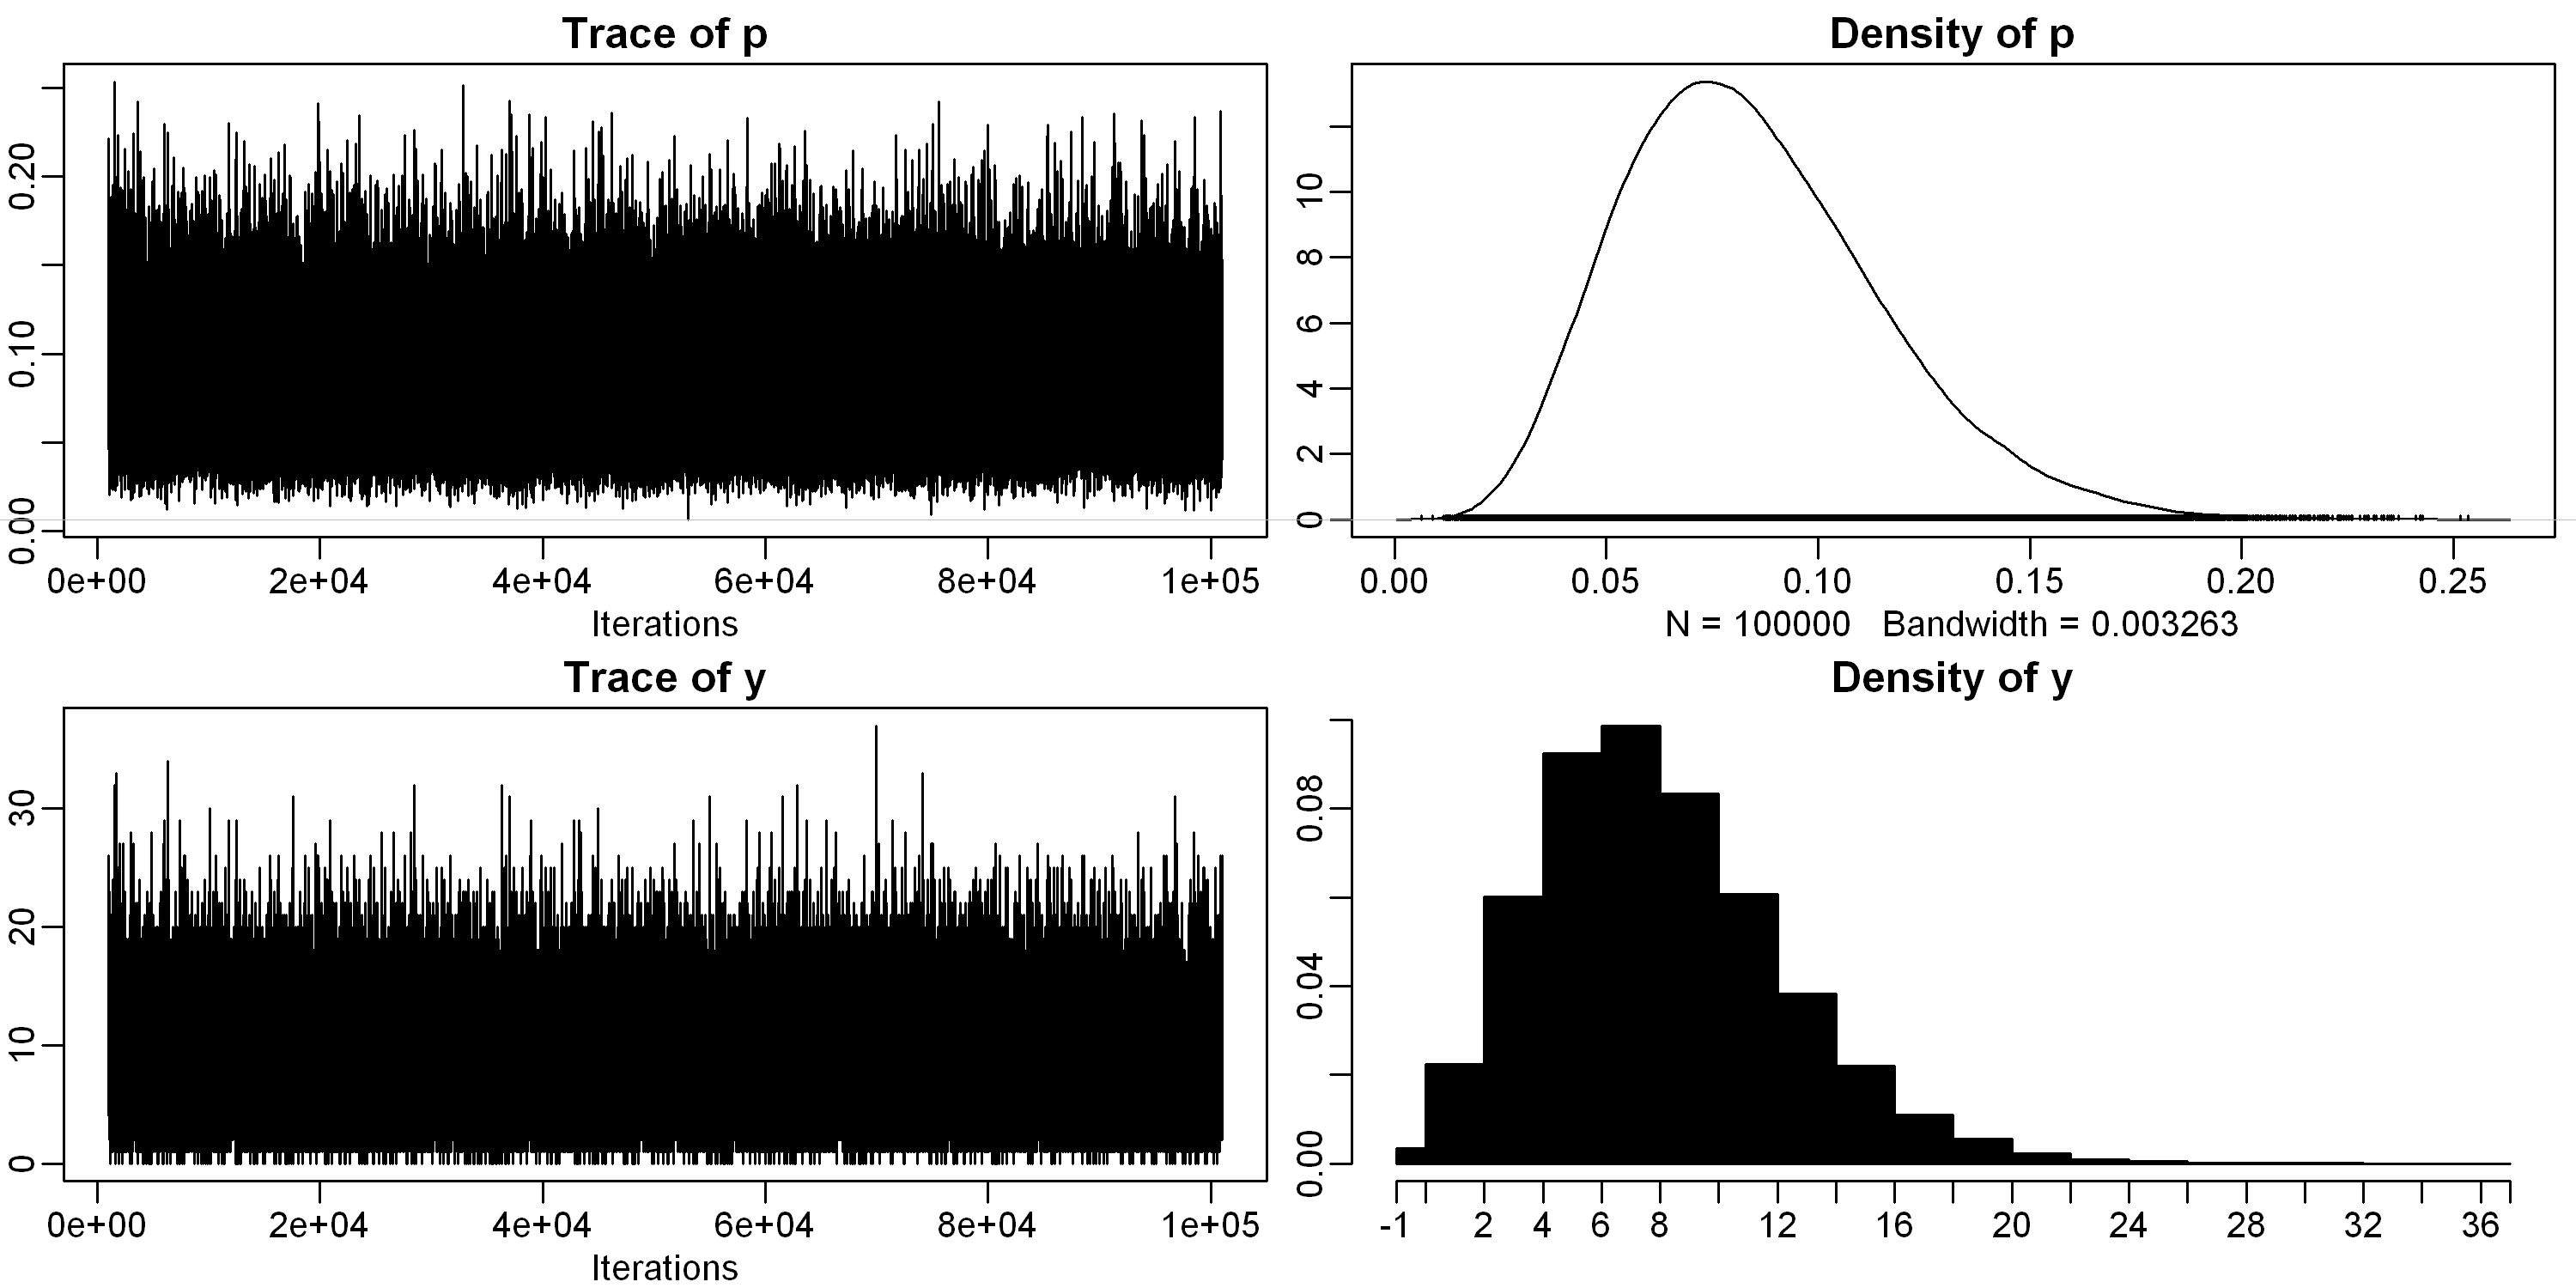

In [34]:
# screening outcome
n <- 75
y <- 6

# prior
prior.mean <- .15
prior.sd   <- .14

# Bayesian inference using JAGS MCMC
results <- jags_mcmc.beta(prior.mean, prior.sd, n_trials=n, n_successes=y, n_predictions=100, burn_in=10^3, n_iterations=10^5, thinning=1, colour='black', seed=5)

In [35]:
# correlation matrix
results$corr_matrix

,p,y
p,1.0000000,0.7445775
y,0.7445775,1.0000000


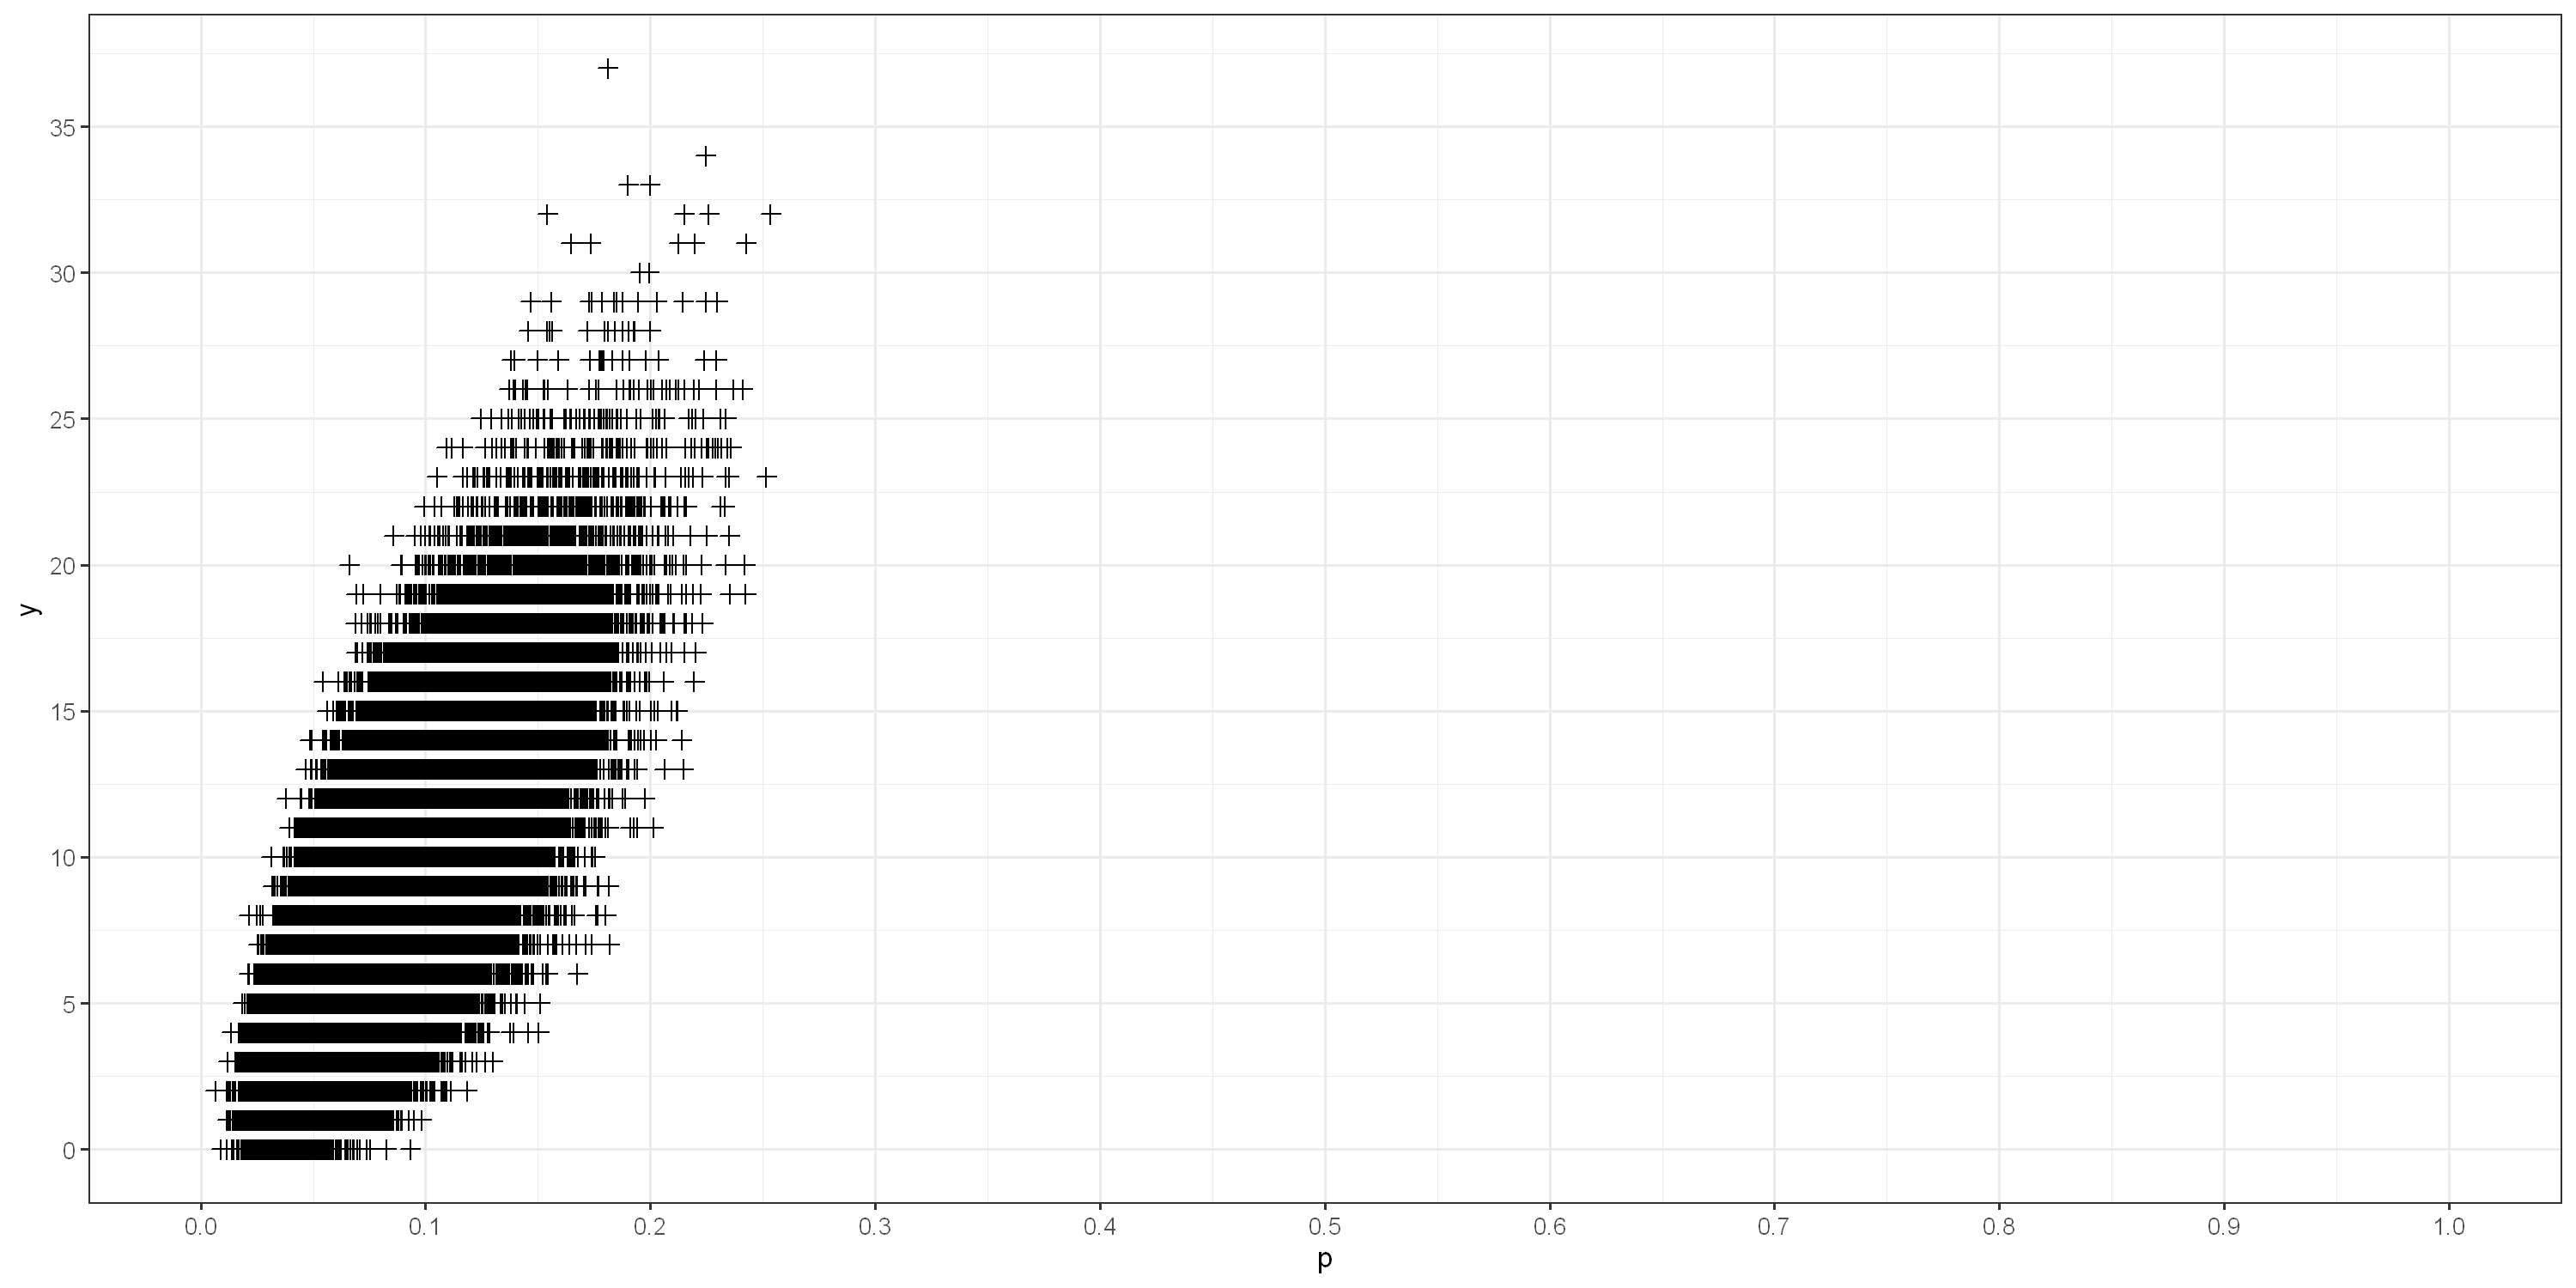

In [36]:
# correlation plot
results$corr_plot

<a id='sec5'></a>
## **Exercise 5**

- ### Analyze the data of **Exercise 2** using a MCMC with JAGS

In [37]:
# function that, given a gamma prior and a Poisson likelihood, performs Bayesian inference using JAGS MCMC
jags_mcmc.gamma <- function(prior.alpha=0, prior.lambda=0, y, observations, burn_in=10^3, n_iterations=10^4, thinning=1, colour='black', seed=5) {

    # set random seed for reproducibility
    set.seed(seed)

    # Poisson sequence
    X <- rep(y, observations) |> sample()

    # likelihood
    likelihood <- 'for (i in 1:length(X)) {X[i] ~ dpois(lambda);}'

    # prior
    prior <- 'lambda ~ dgamma(prior.alpha, prior.lambda + 10^-10);'

    # predictions
    predictions <- 'y ~ dpois(lambda);'

    # list containing the data for the model
    data <- list('X'=X, 'prior.alpha'=prior.alpha, 'prior.lambda'=prior.lambda)

    # BUGS model
    bugs_model <- paste('model {', likelihood, prior, predictions, '}') |> textConnection()

    # JAGS model
    jags_model <- jags.model(file=bugs_model, data=data, inits=list('.RNG.name'='base::Mersenne-Twister', '.RNG.seed'=seed))

    # update the JAGS model ("burn-in" period)
    update(object=jags_model, n.iter=burn_in)

    # generate posterior samples
    mcmc <- coda.samples(model=jags_model, variable.names=c('lambda', 'y'), n.iter=n_iterations, thin=thinning)
    print(summary(mcmc))

    # MCMC plot
    options(repr.plot.width=10, repr.plot.height=5)
    par(mar=c(2.5, 1.5, 1.5, .5), mgp=c(1.5, .5, 0), oma=c(0, 0, 0, 0), xpd=NA)
    plot(mcmc, col=colour)

    # correlation matrix
    corr_matrix <- mcmc |> as.mcmc() |> cor()

    # correlation plot
    corr_plot <- ggplot(data = mcmc |> as.mcmc() |> as_tibble(), aes(x=lambda, y=y)) +
                    geom_point(colour=colour, shape='plus') +
                    scale_x_continuous(n.breaks=11) +
                    scale_y_continuous(n.breaks=7)

    return(list('corr_matrix'=corr_matrix, 'corr_plot'=corr_plot))

}

In [38]:
# death soldiers
y <- c(0, 1, 2, 3, 4)

# observations
n1 <- c(109, 65, 22, 3,  1)
n2 <- c(144, 91, 32, 11, 2)

# uniform prior
prior_unif.alpha  <- 1
prior_unif.lambda <- 0

# Jeffreys prior
prior_jeffreys.alpha  <- 1 / 2
prior_jeffreys.lambda <- 0

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 209

Initializing model


Iterations = 1001:101000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
lambda 0.615 0.05553 0.0001756      0.0001756
y      0.613 0.78907 0.0024953      0.0024953

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
lambda 0.5112 0.5766 0.6132 0.6518 0.7288
y      0.0000 0.0000 0.0000 1.0000 3.0000



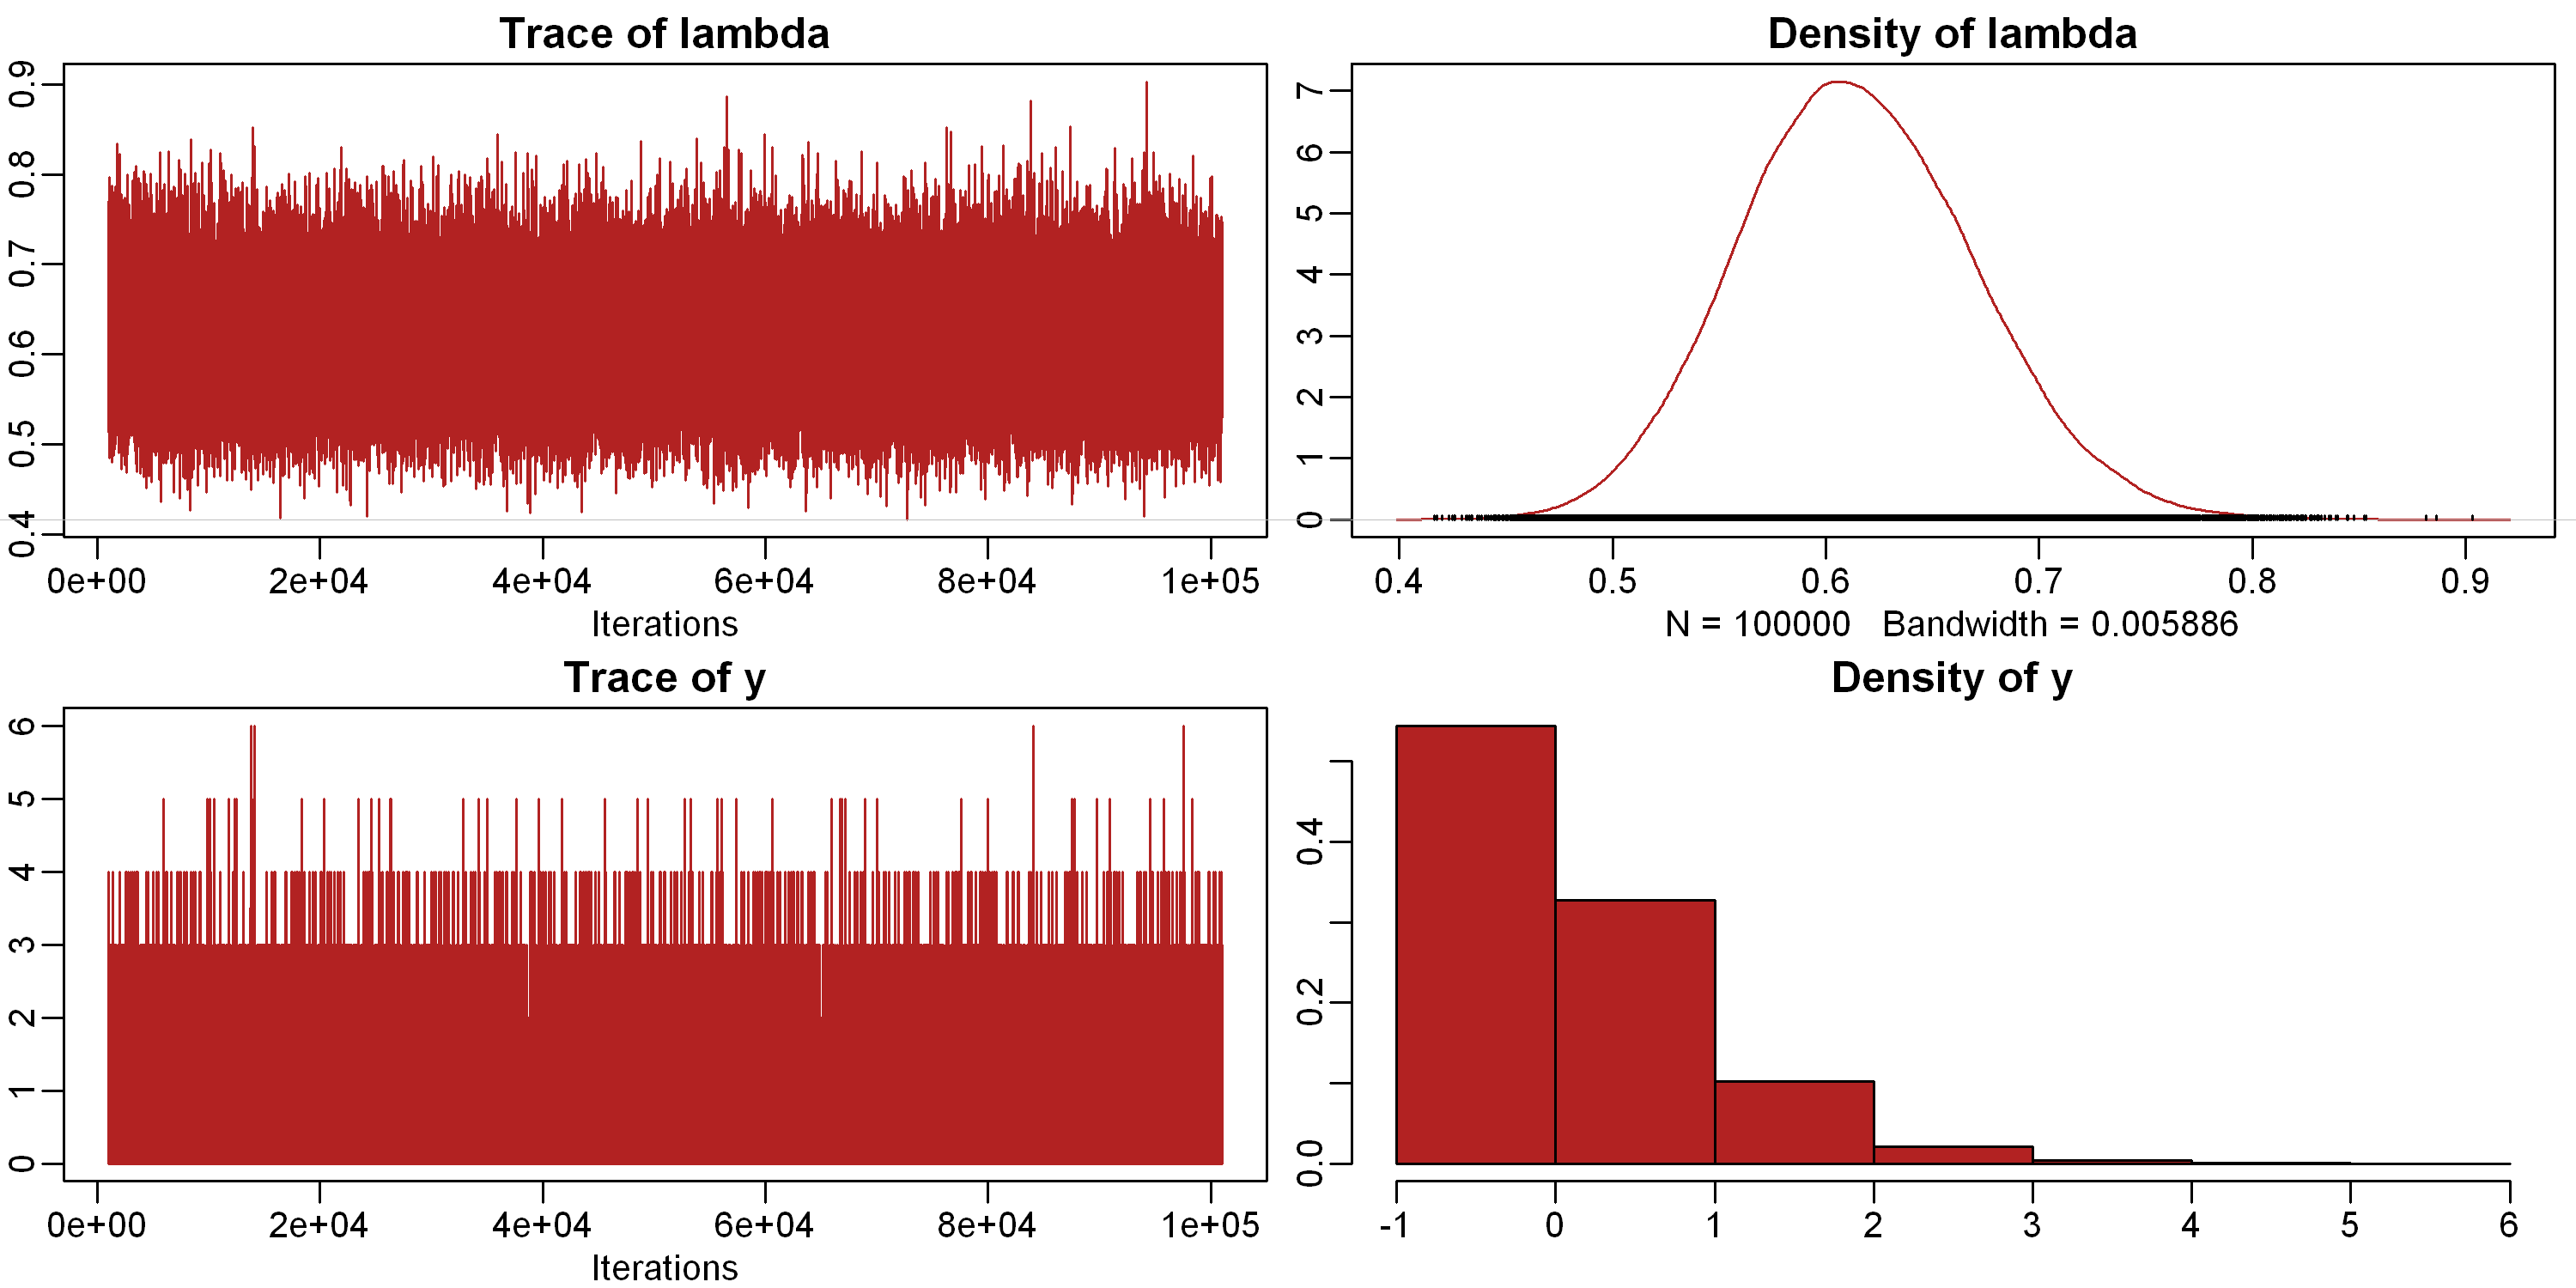

In [39]:
# Bayesian inference using JAGS MCMC (uniform prior, observation set 'n1')
results <- jags_mcmc.gamma(prior_unif.alpha, prior_unif.lambda, y, n1, burn_in=10^3, n_iterations=10^5, thinning=1, colour='firebrick', seed=5)

In [40]:
# correlation matrix (uniform prior, observation set 'n1')
results$corr_matrix

,lambda,y
lambda,1.00000000,0.06895403
y,0.06895403,1.00000000


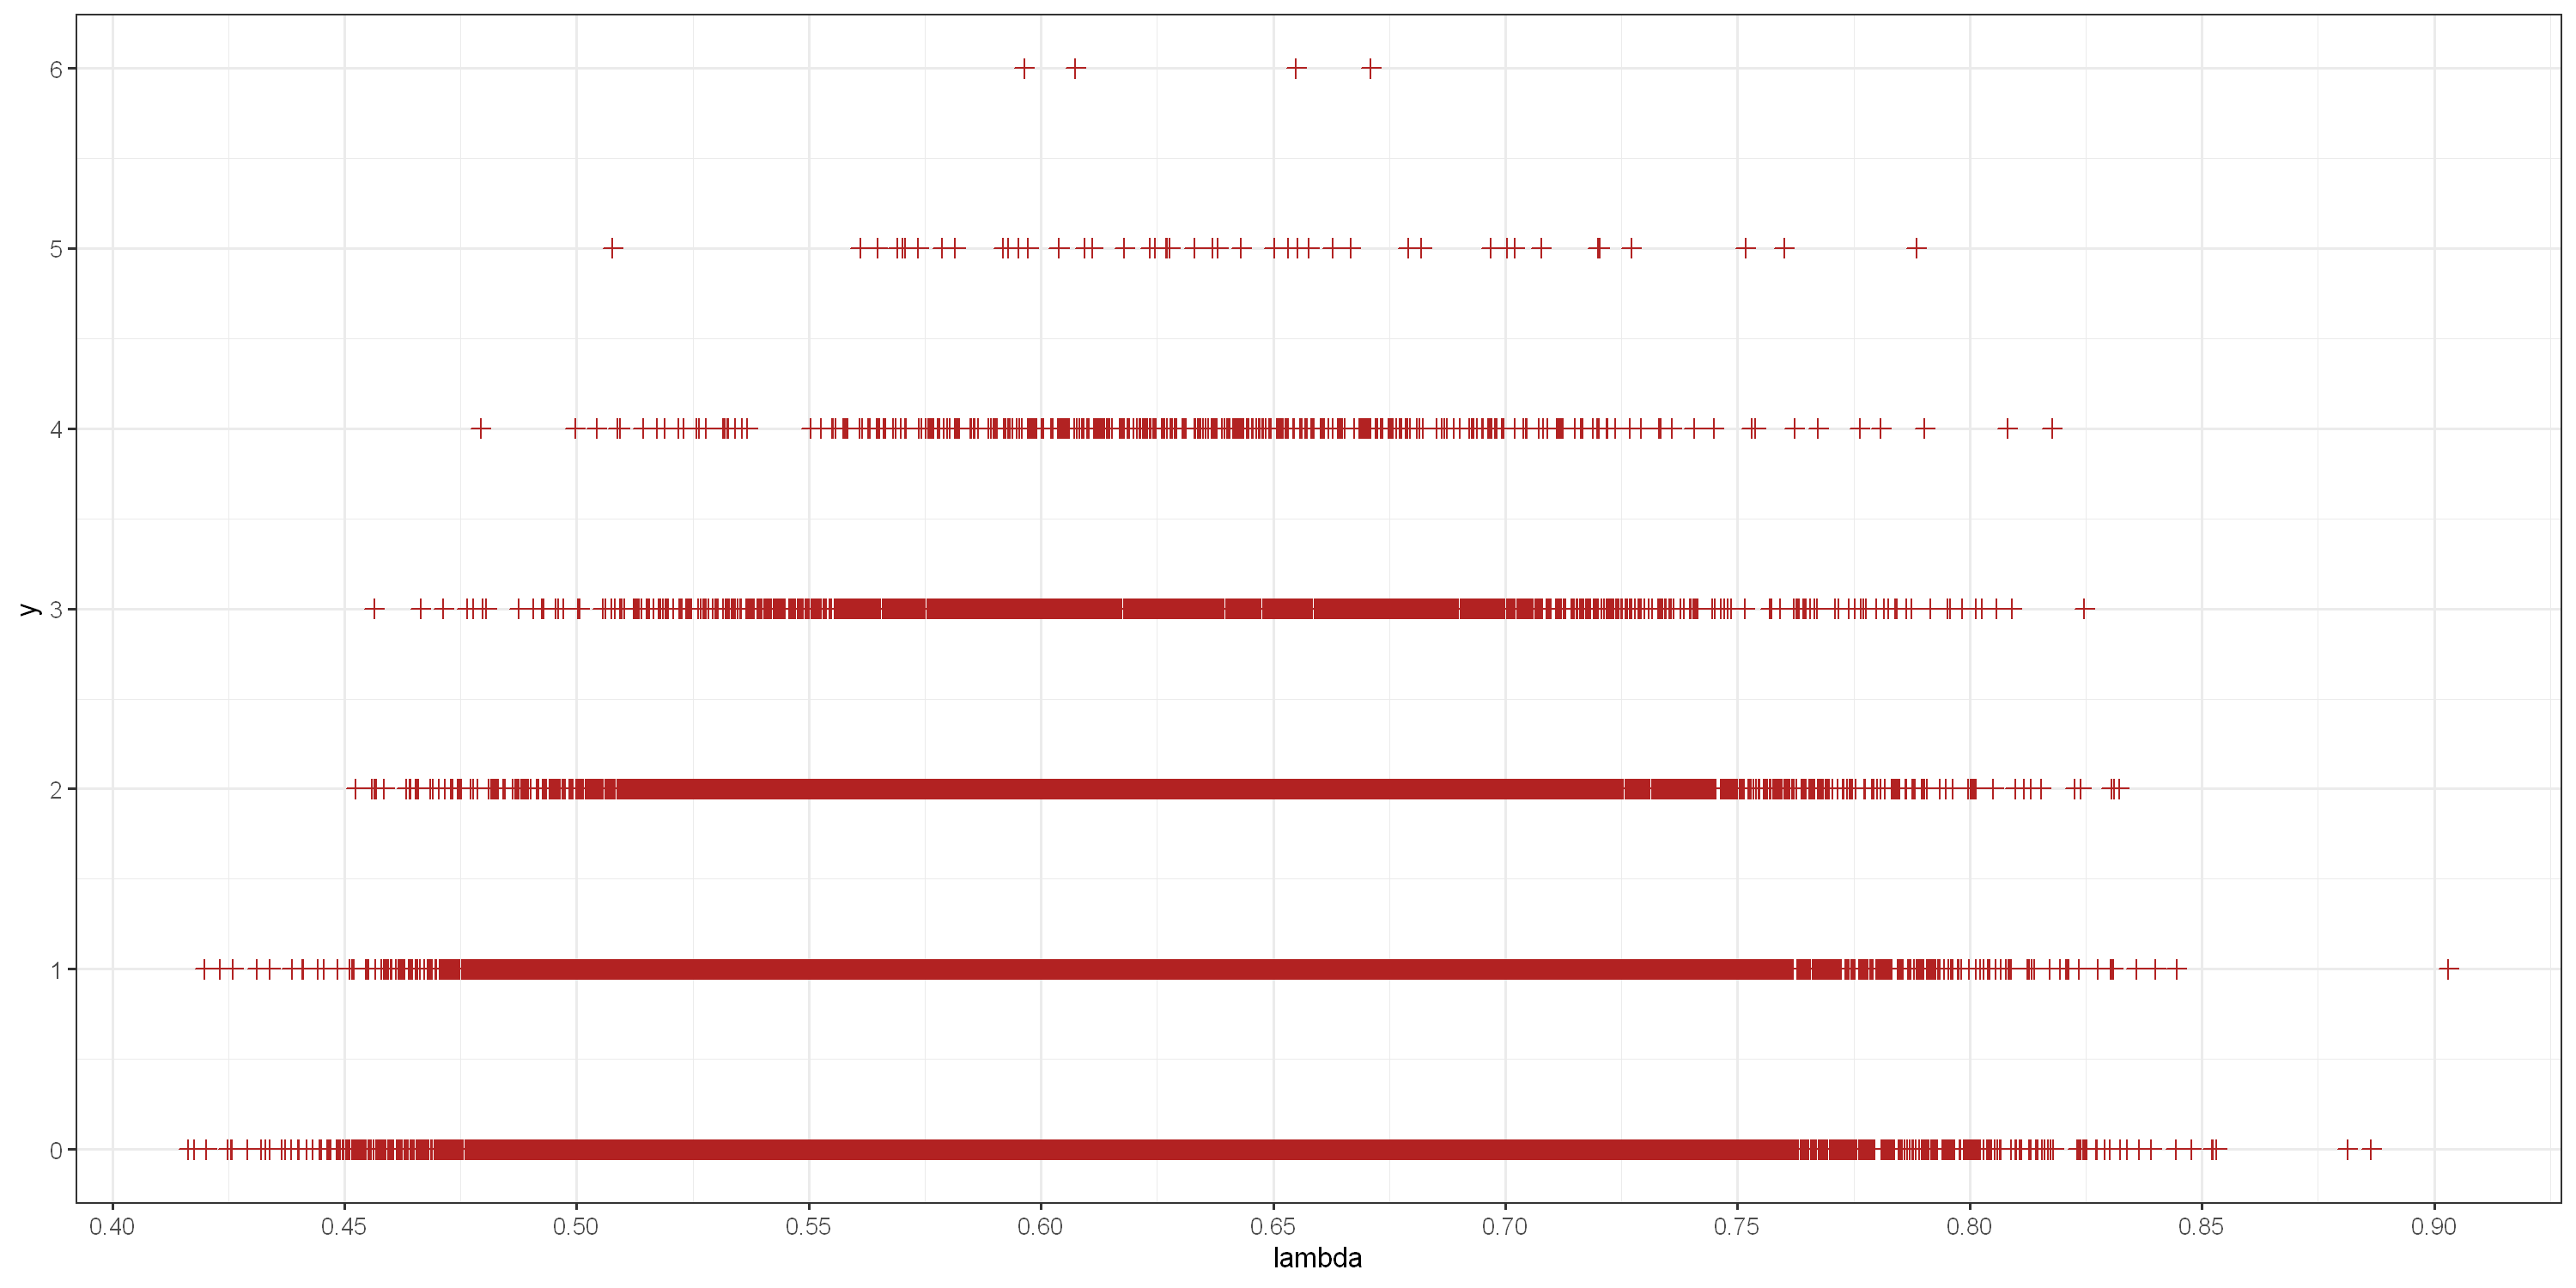

In [41]:
# correlation plot (uniform prior, observation set 'n1')
results$corr_plot

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 2
   Total graph size: 289

Initializing model


Iterations = 1001:101000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
lambda 0.7036 0.05021 0.0001588      0.0001588
y      0.7018 0.84347 0.0026673      0.0026673

2. Quantiles for each variable:

         2.5%   25%    50%    75%  97.5%
lambda 0.6088 0.669 0.7022 0.7371 0.8055
y      0.0000 0.000 1.0000 1.0000 3.0000



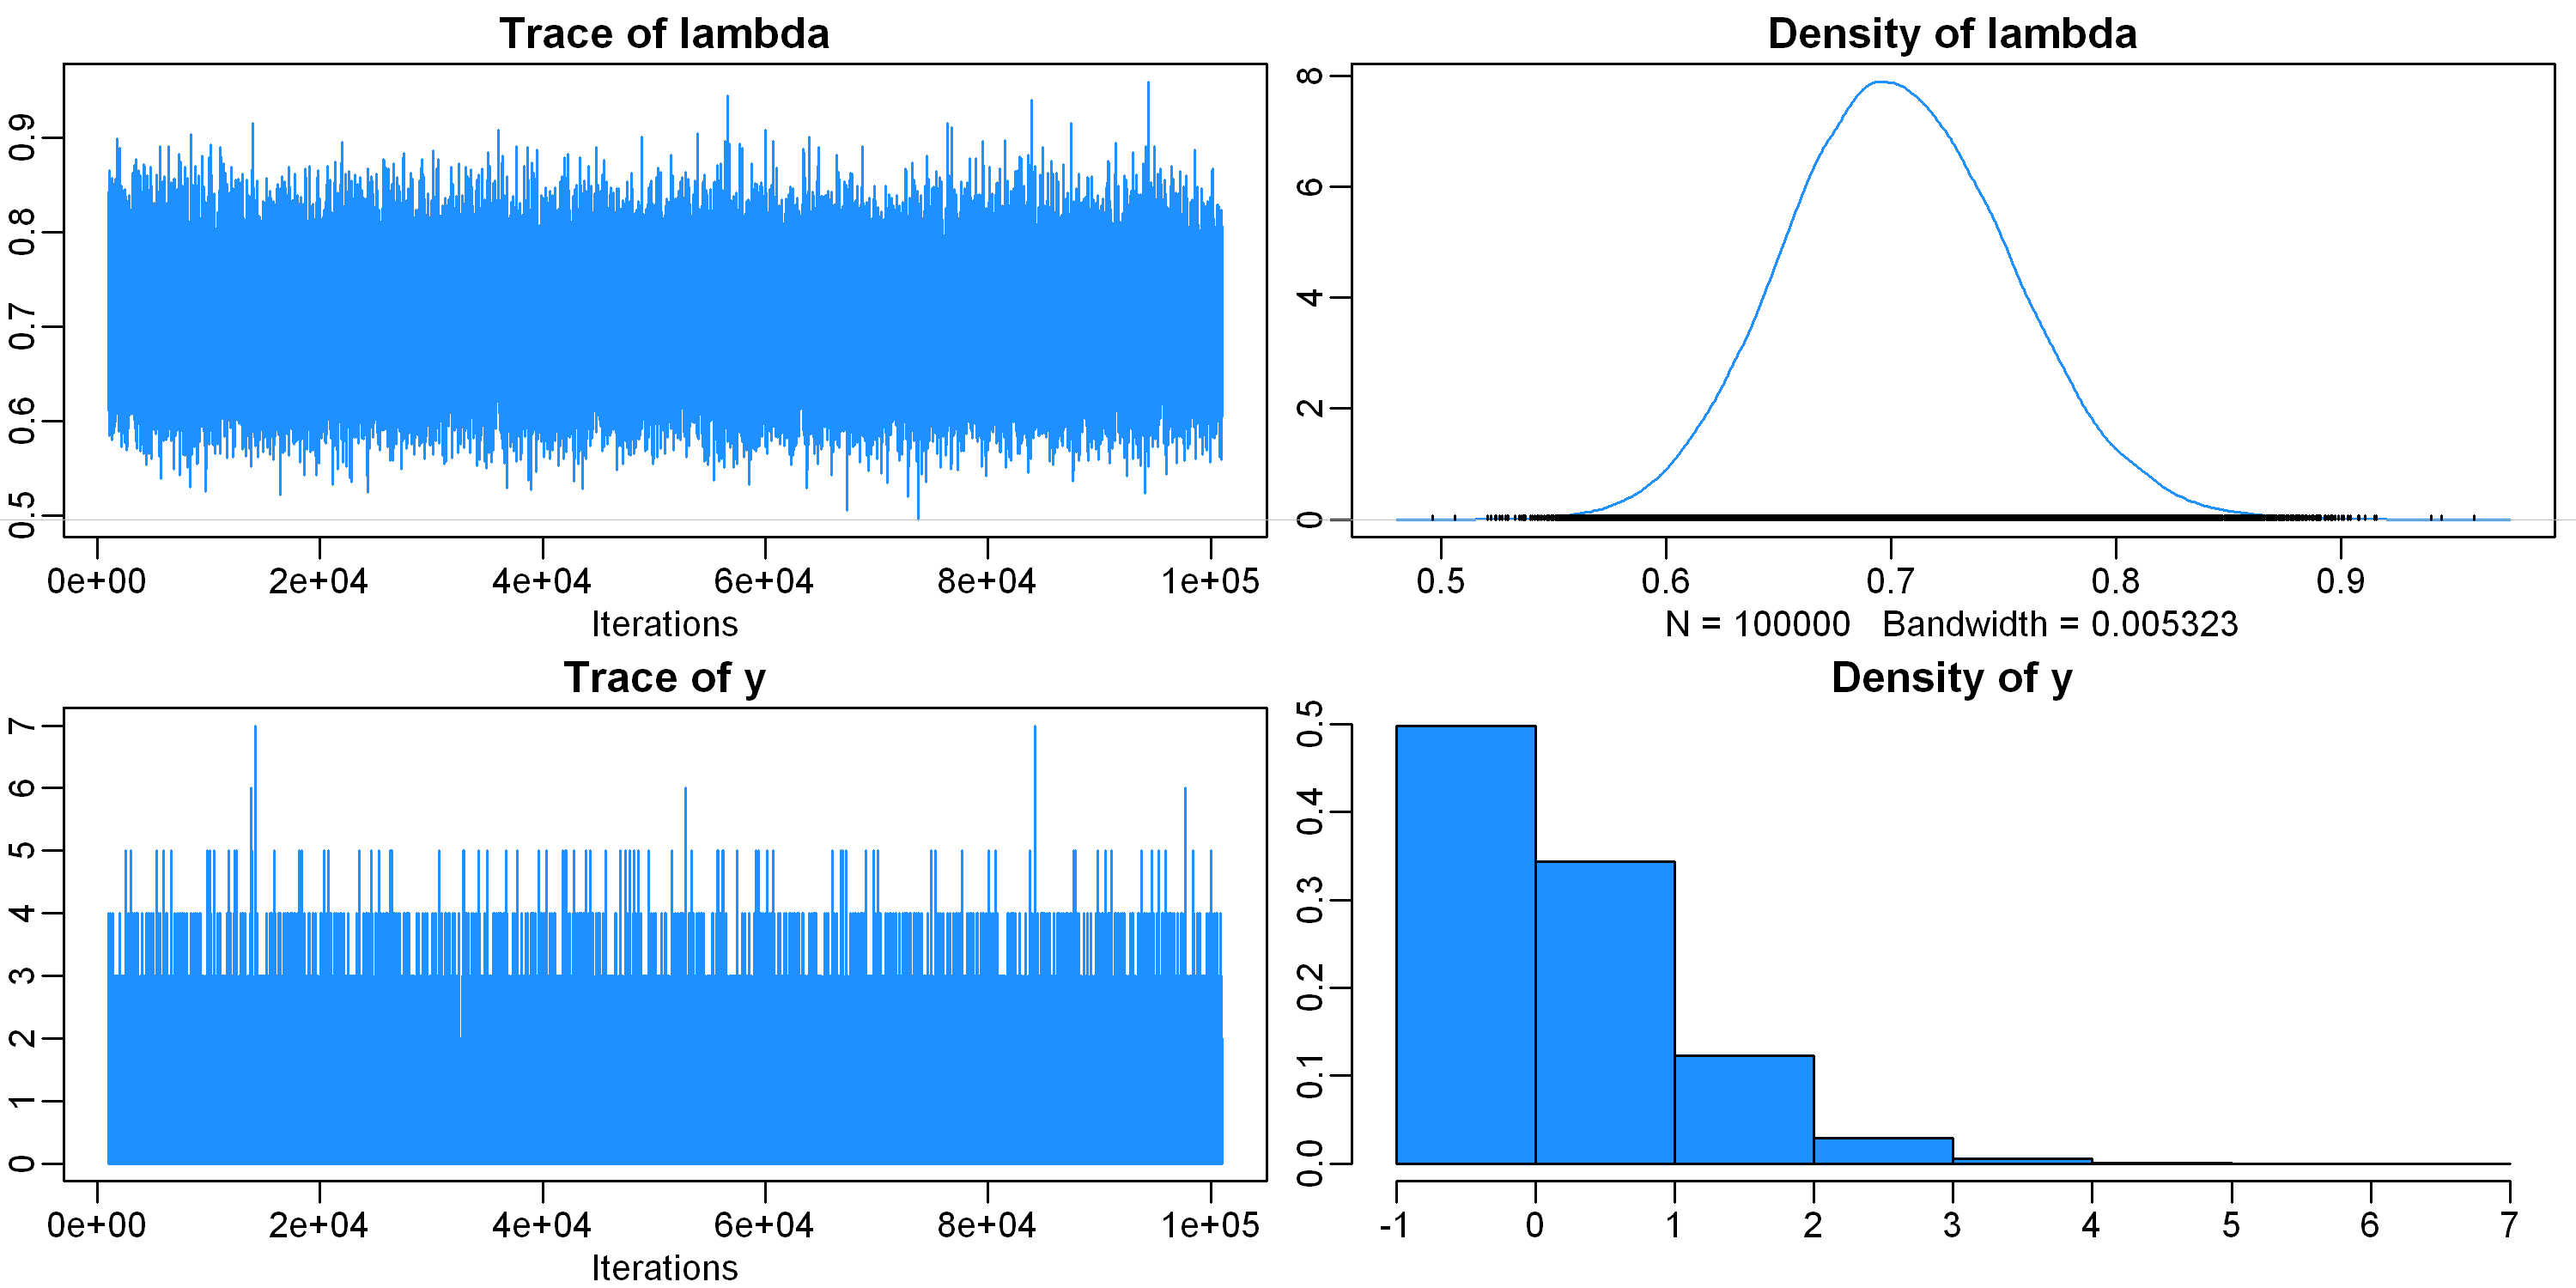

In [42]:
# Bayesian inference using JAGS MCMC (uniform prior, observation set 'n2')
results <- jags_mcmc.gamma(prior_unif.alpha, prior_unif.lambda, y, n2, burn_in=10^3, n_iterations=10^5, thinning=1, colour='dodgerblue', seed=5)

In [43]:
# correlation matrix (uniform prior, observation set 'n2')
results$corr_matrix

,lambda,y
lambda,1.00000000,0.05718993
y,0.05718993,1.00000000


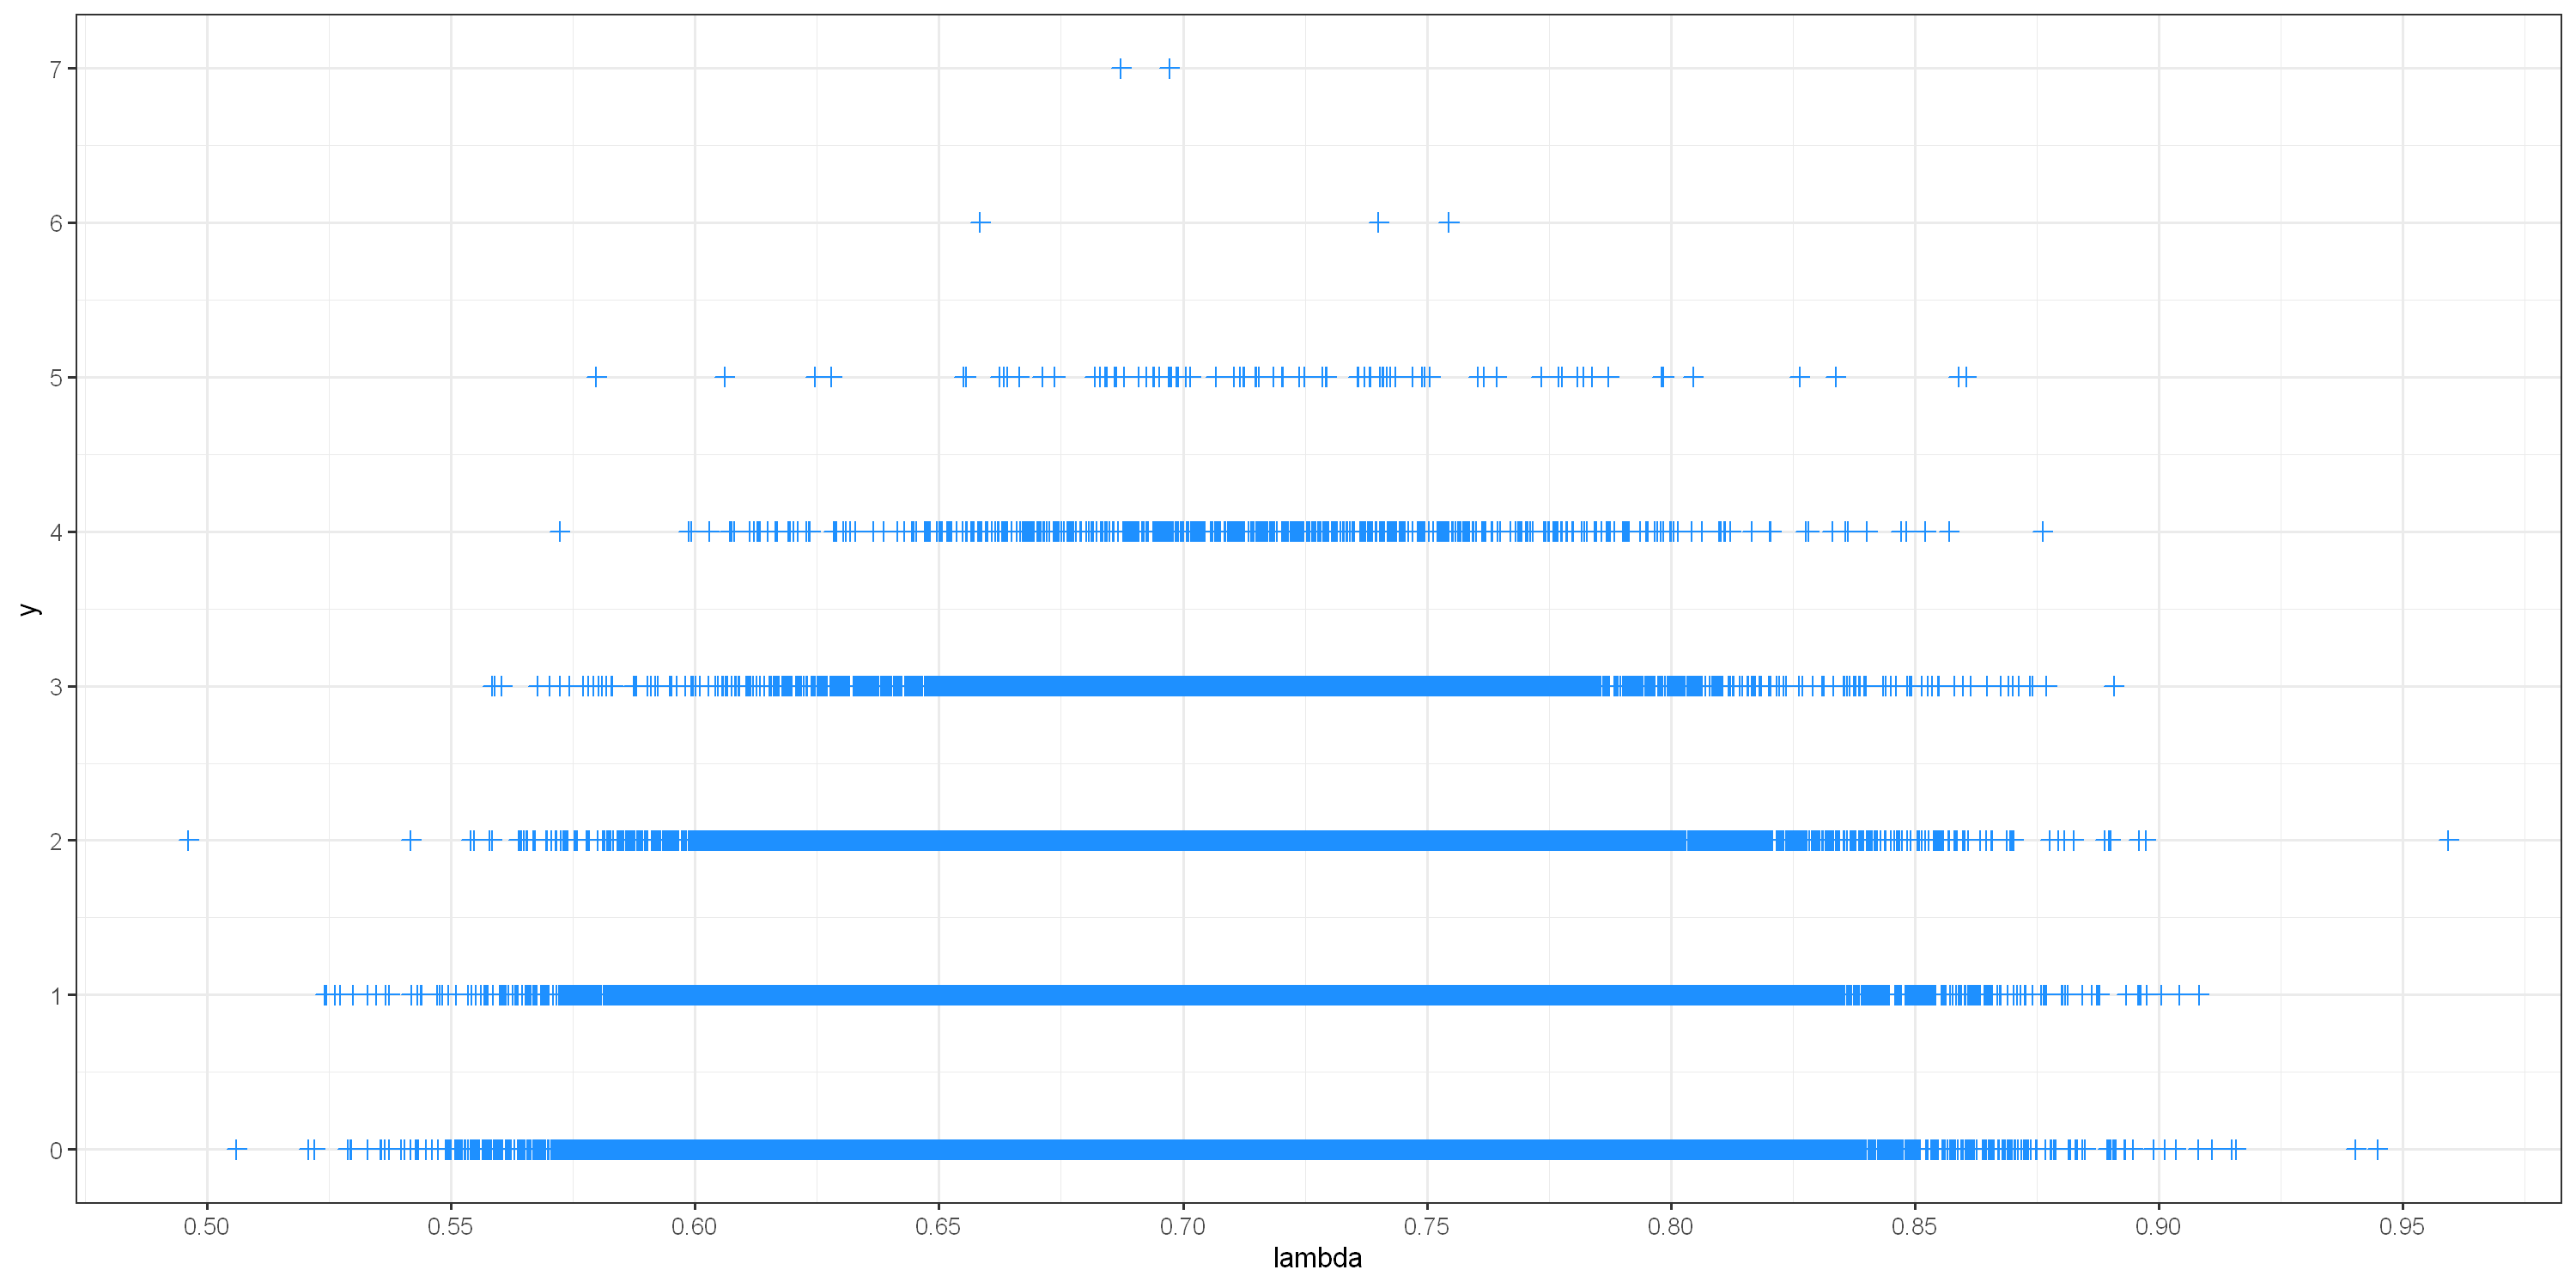

In [44]:
# correlation plot (uniform prior, observation set 'n2')
results$corr_plot

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 209

Initializing model


Iterations = 1001:101000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
lambda 0.6125 0.05541 0.0001752      0.0001752
y      0.6107 0.78760 0.0024906      0.0024906

2. Quantiles for each variable:

        2.5%    25%    50%    75%  97.5%
lambda 0.509 0.5741 0.6107 0.6493 0.7261
y      0.000 0.0000 0.0000 1.0000 2.0000



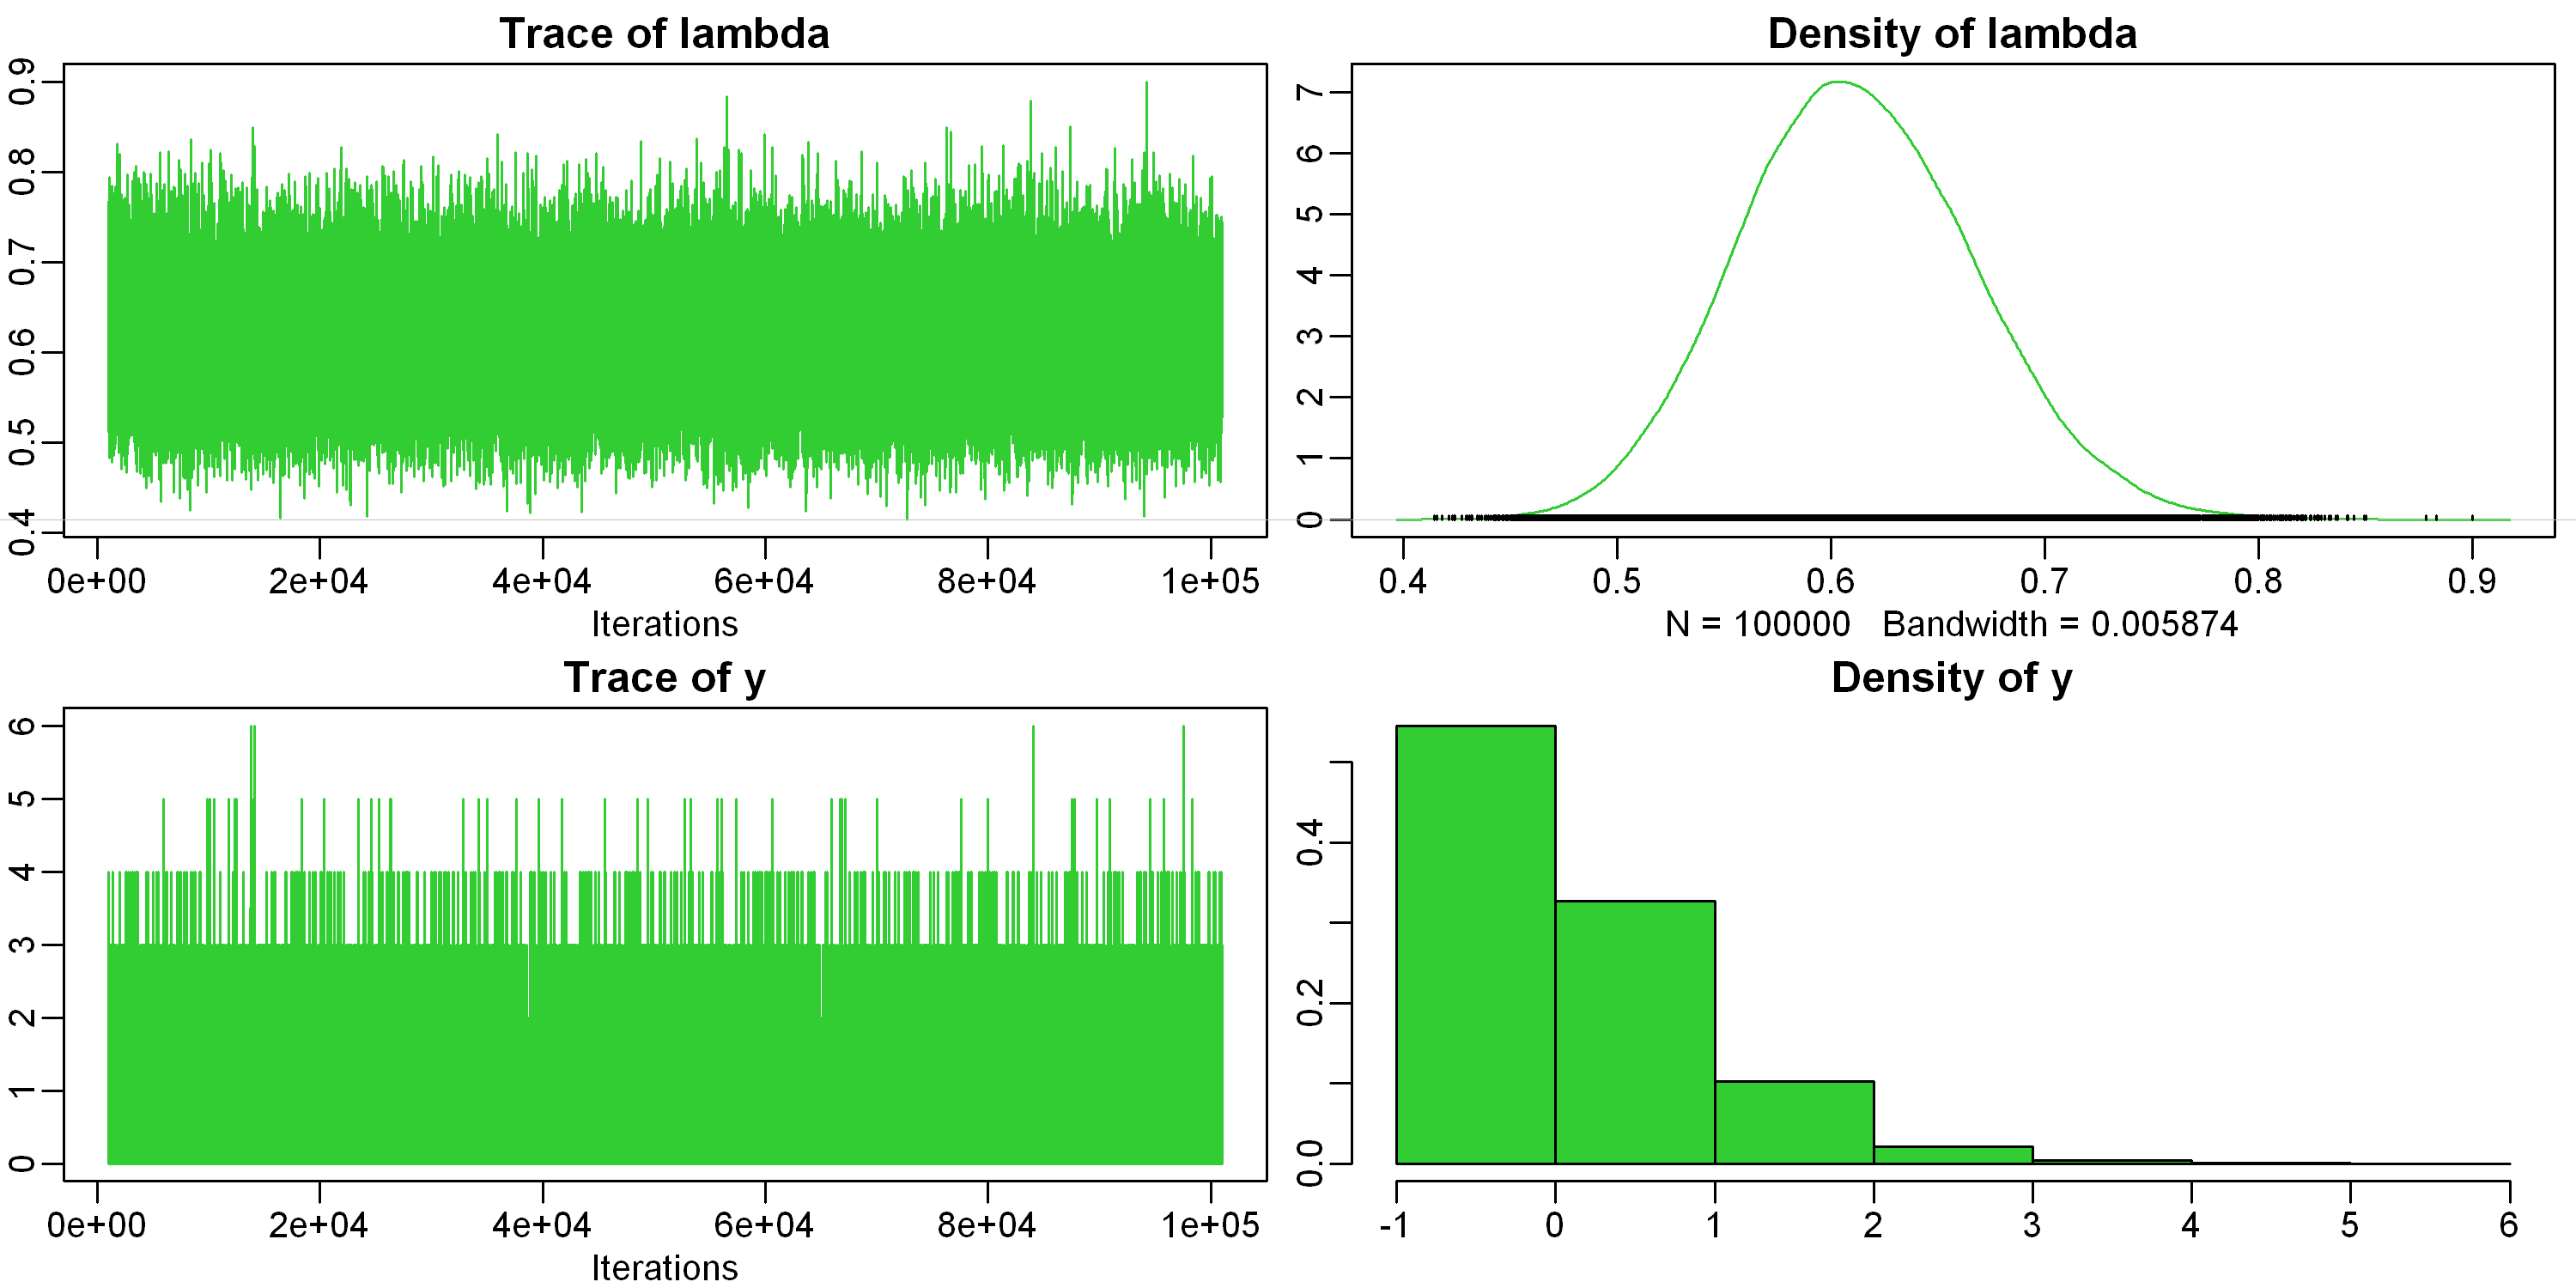

In [45]:
# Bayesian inference using JAGS MCMC (Jeffreys prior, observation set 'n1')
results <- jags_mcmc.gamma(prior_jeffreys.alpha, prior_jeffreys.lambda, y, n1, burn_in=10^3, n_iterations=10^5, thinning=1, colour='limegreen', seed=5)

In [46]:
# correlation matrix (Jeffreys prior, observation set 'n1')
results$corr_matrix

,lambda,y
lambda,1.00000000,0.06892514
y,0.06892514,1.00000000


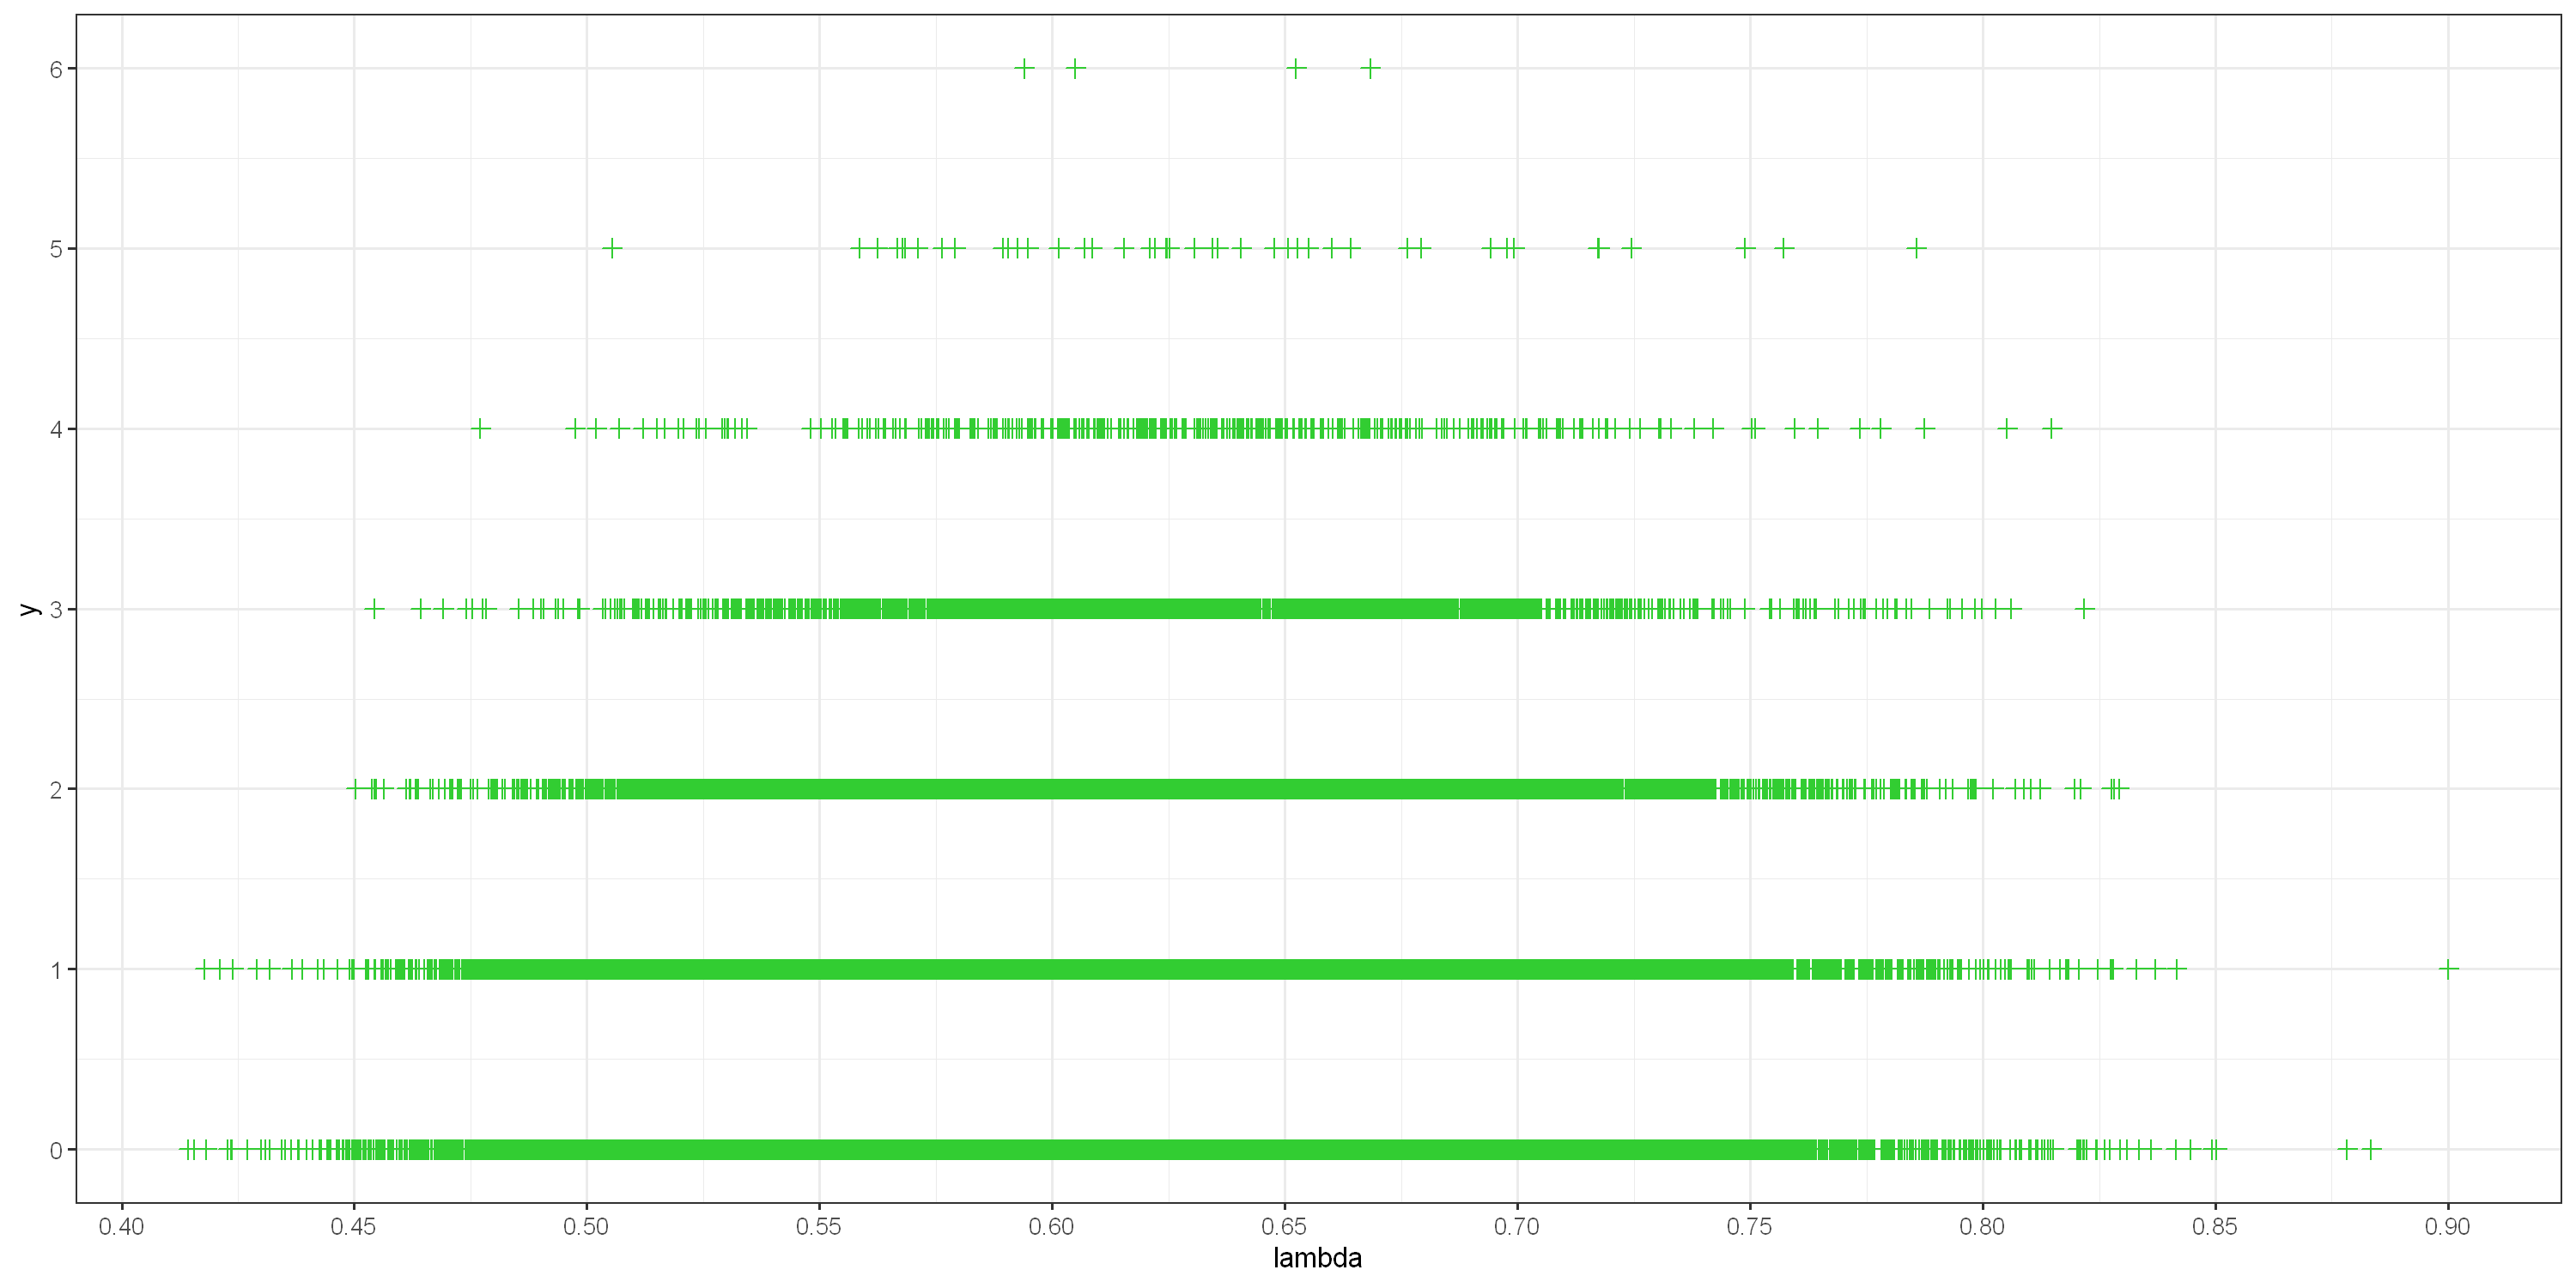

In [47]:
# correlation plot (Jeffreys prior, observation set 'n1')
results$corr_plot

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 280
   Unobserved stochastic nodes: 2
   Total graph size: 289

Initializing model


Iterations = 1001:101000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean      SD  Naive SE Time-series SE
lambda 0.7018 0.05015 0.0001586      0.0001586
y      0.7000 0.84246 0.0026641      0.0026641

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
lambda 0.6071 0.6672 0.7004 0.7352 0.8036
y      0.0000 0.0000 1.0000 1.0000 3.0000



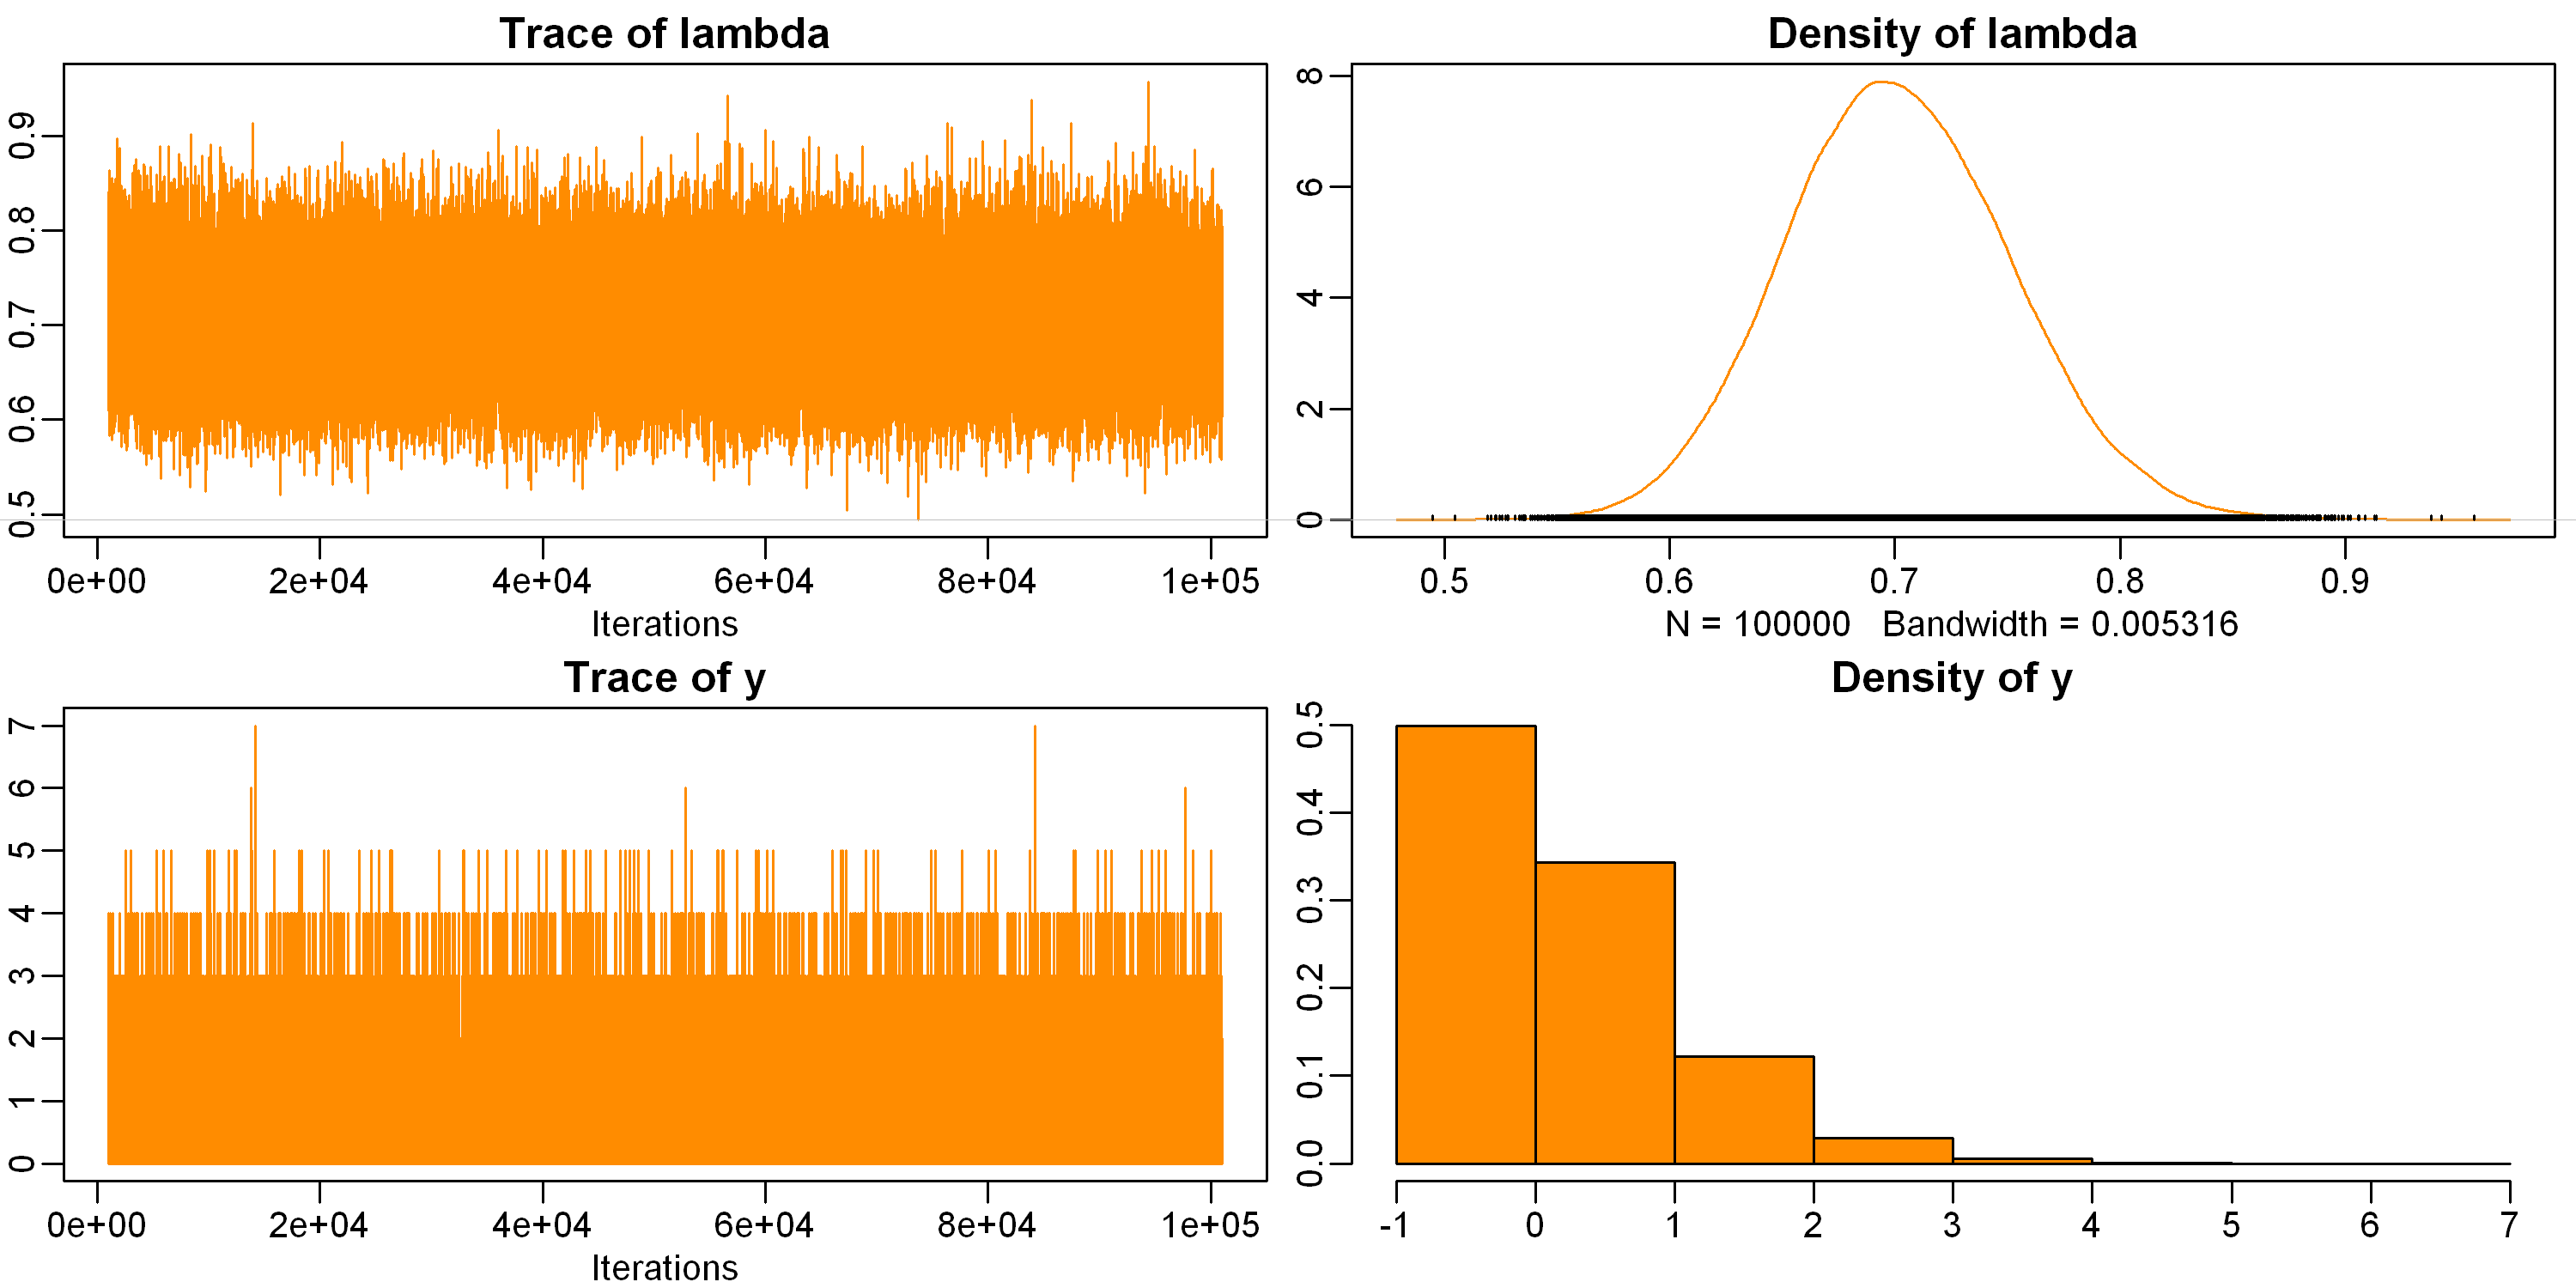

In [48]:
# Bayesian inference using JAGS MCMC (Jeffreys prior, observation set 'n2')
results <- jags_mcmc.gamma(prior_jeffreys.alpha, prior_jeffreys.lambda, y, n2, burn_in=10^3, n_iterations=10^5, thinning=1, colour='darkorange', seed=5)

In [49]:
# correlation matrix (Jeffreys prior, observation set 'n2')
results$corr_matrix

,lambda,y
lambda,1.00000000,0.05713399
y,0.05713399,1.00000000


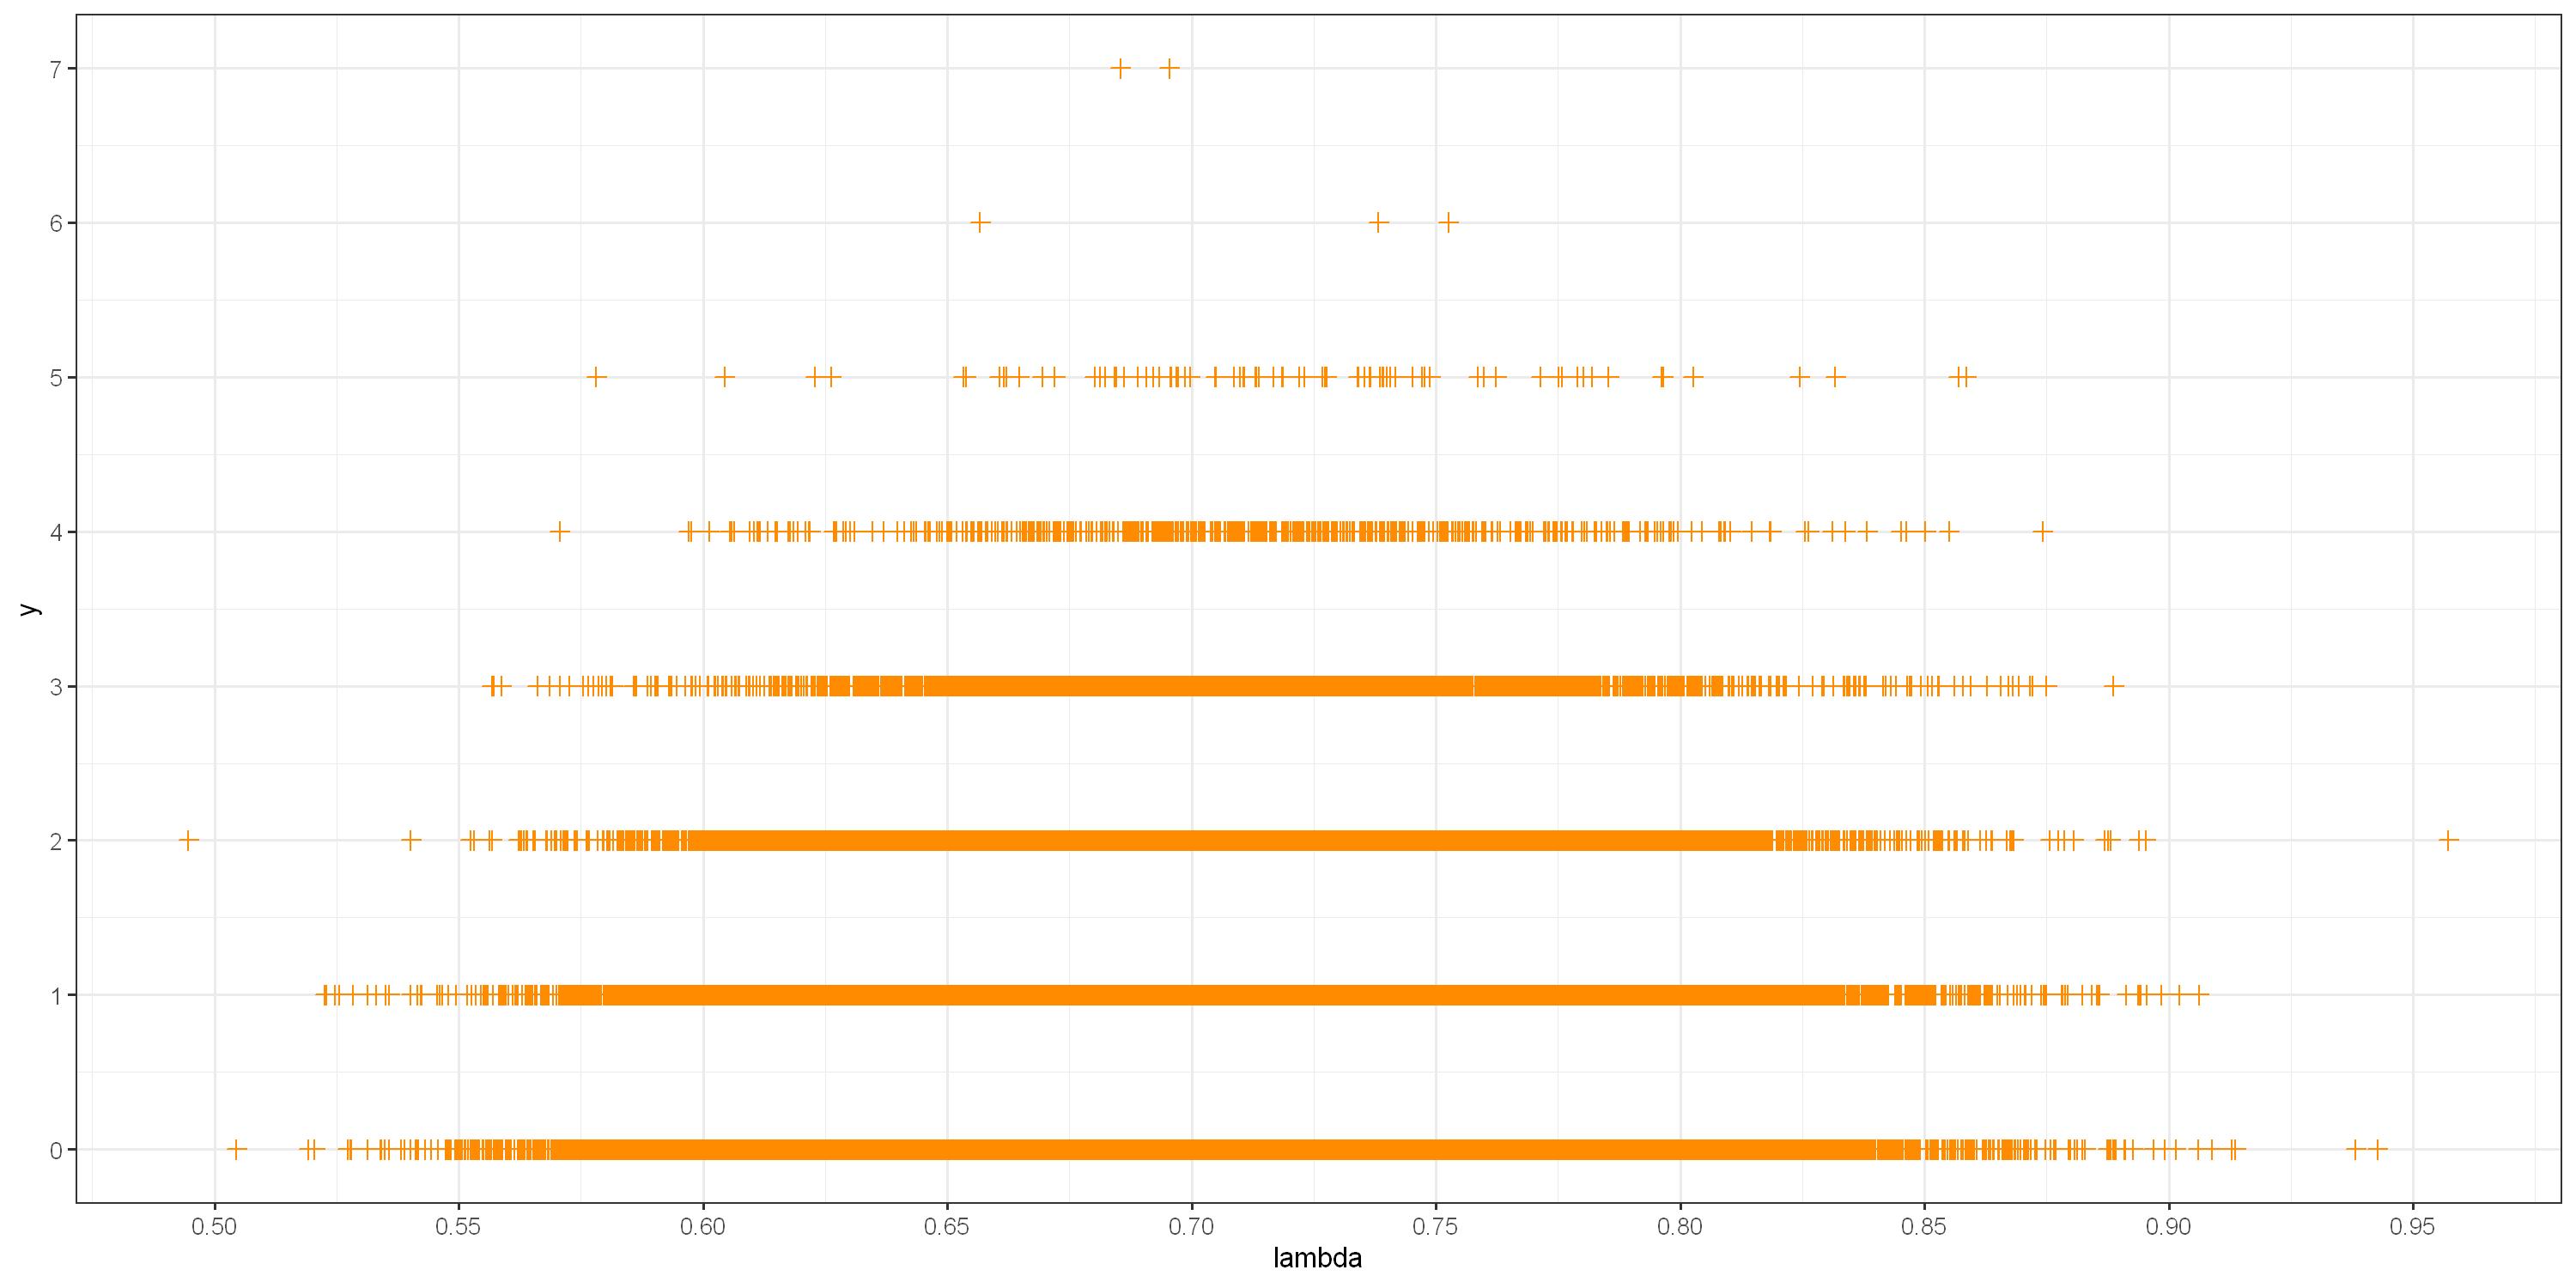

In [50]:
# correlation plot (Jeffreys prior, observation set 'n2')
results$corr_plot

<a id='sec6'></a>
## **Exercise 6**

- ### Analyze the data of **Exercise 3** using a MCMC with JAGS (solve **3.B** and **3.C**)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 116
   Unobserved stochastic nodes: 2
   Total graph size: 121

Initializing model


Iterations = 1001:101000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

     Mean      SD  Naive SE Time-series SE
p 0.09437 0.02582 8.166e-05      8.166e-05
y 9.43363 3.89340 1.231e-02      1.231e-02

2. Quantiles for each variable:

     2.5%     25%     50%     75%   97.5%
p 0.05018 0.07585 0.09224  0.1107  0.1509
y 3.00000 7.00000 9.00000 12.0000 18.0000



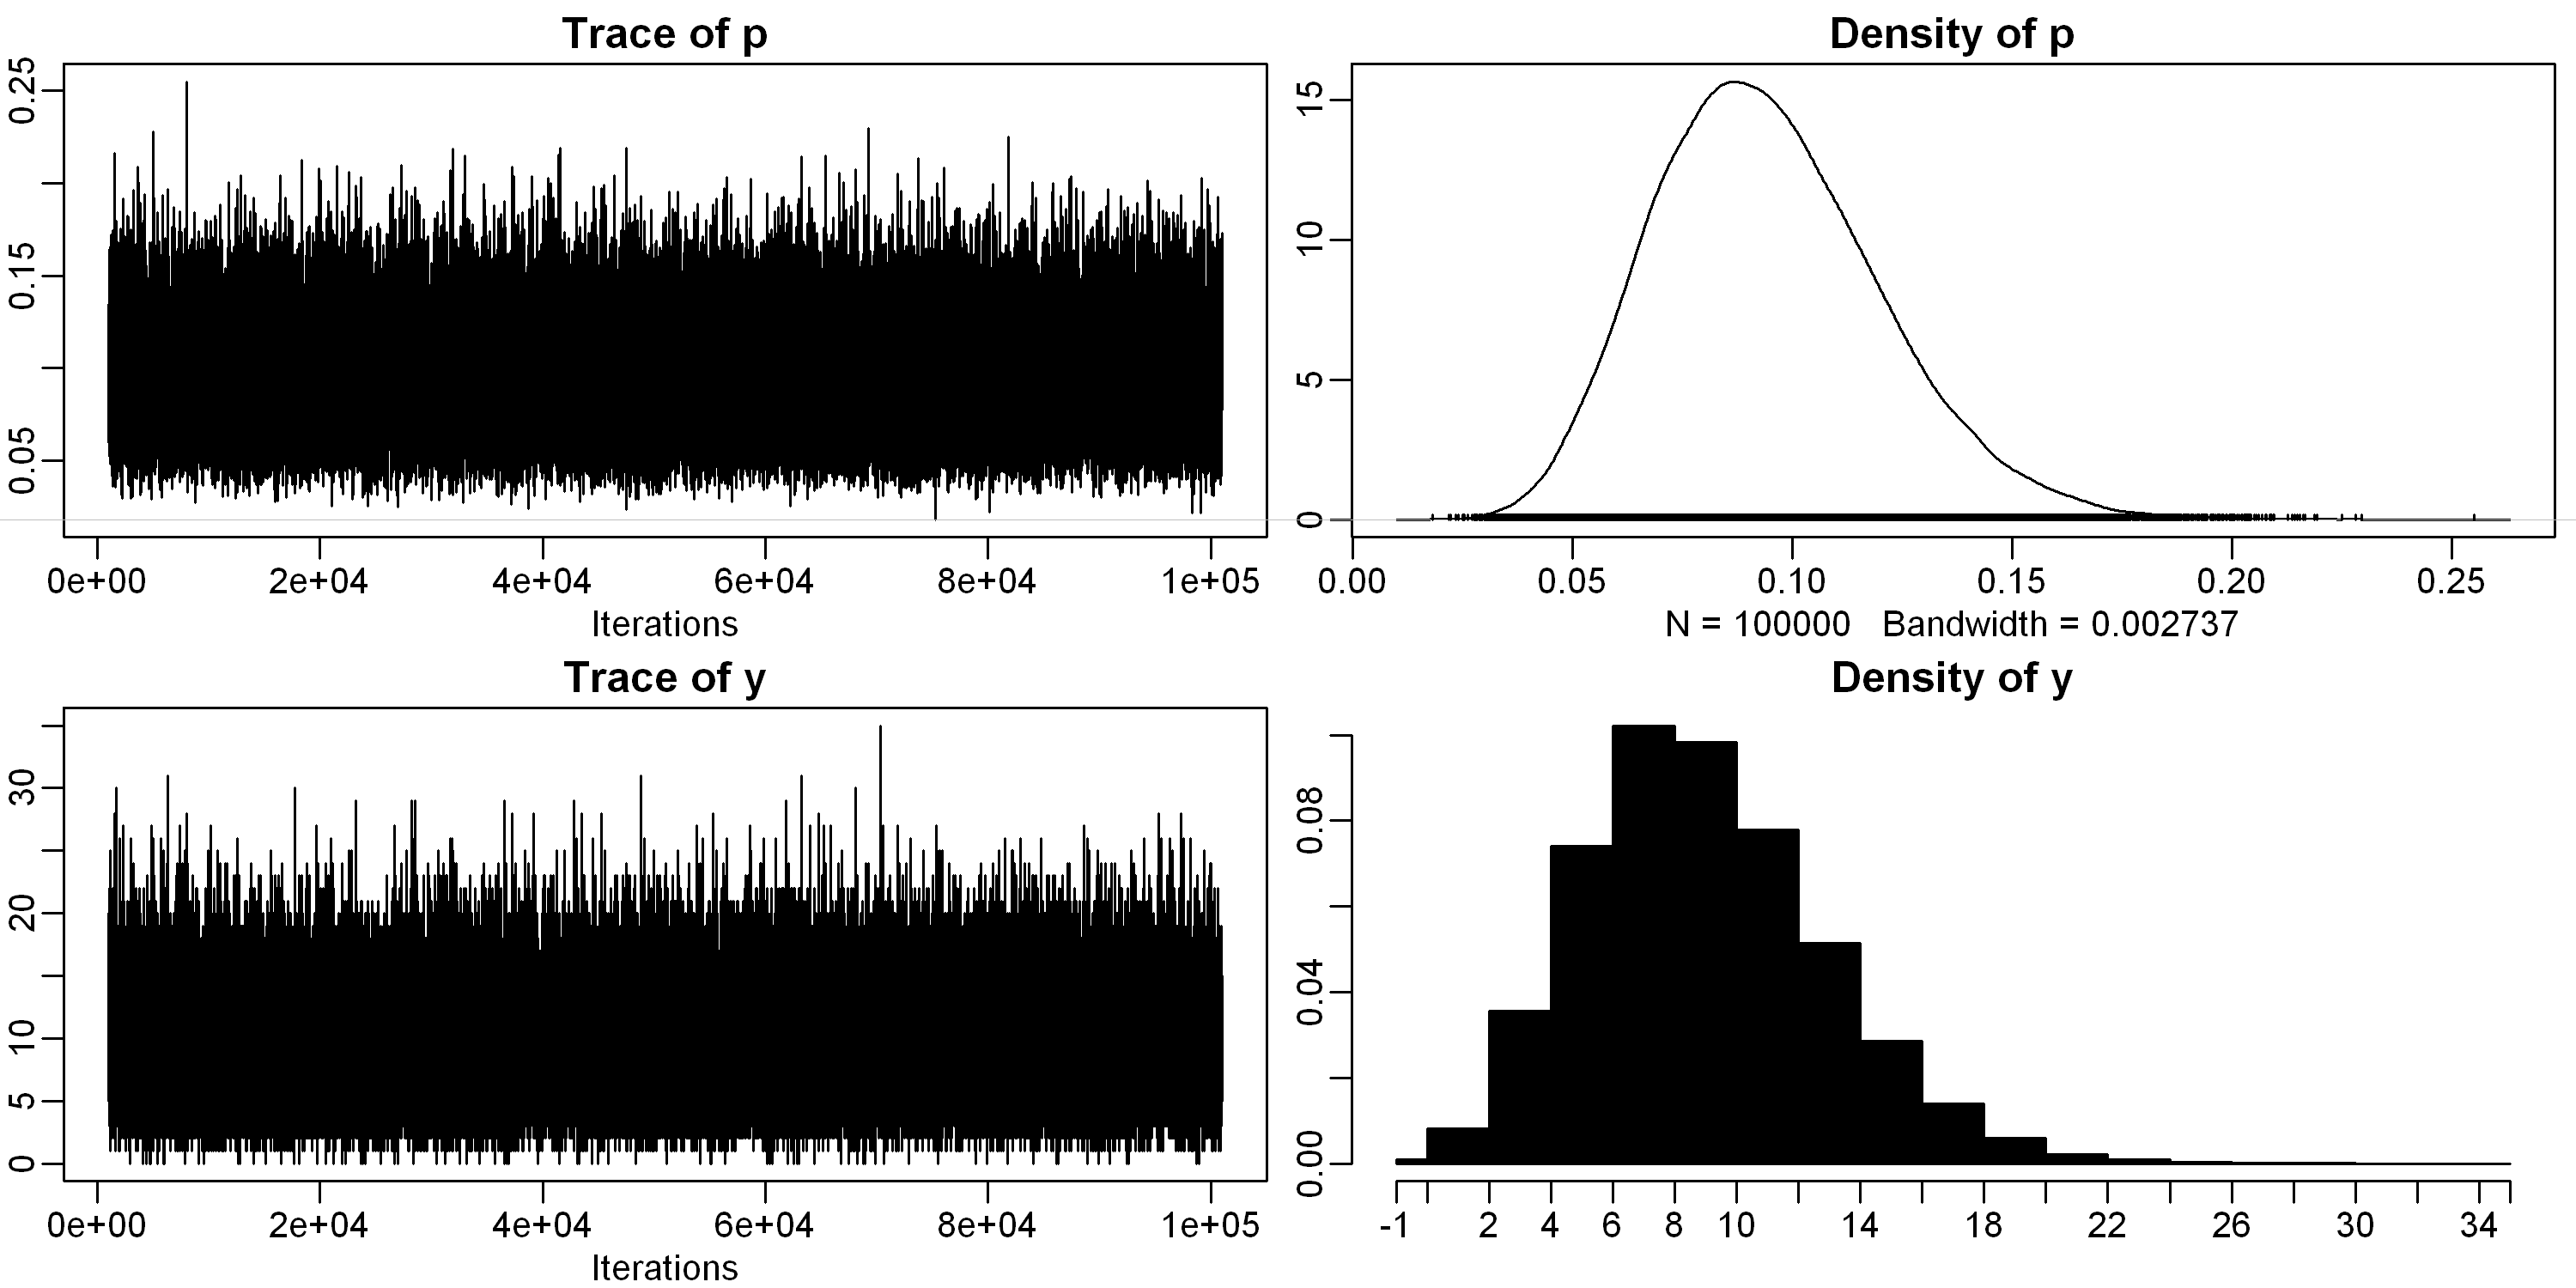

In [51]:
# analysis outcome
n <- 116
y <- 11

# prior
prior.alpha <- 1
prior.beta  <- 10

# Bayesian inference using JAGS MCMC
results <- jags_mcmc.beta(prior.alpha=prior.alpha, prior.beta=prior.beta, n_trials=n, n_successes=y, n_predictions=100, burn_in=10^3, n_iterations=10^5, thinning=1, colour='black', seed=5)

In [52]:
# correlation matrix
results$corr_matrix

,p,y
p,1.0000000,0.6630885
y,0.6630885,1.0000000


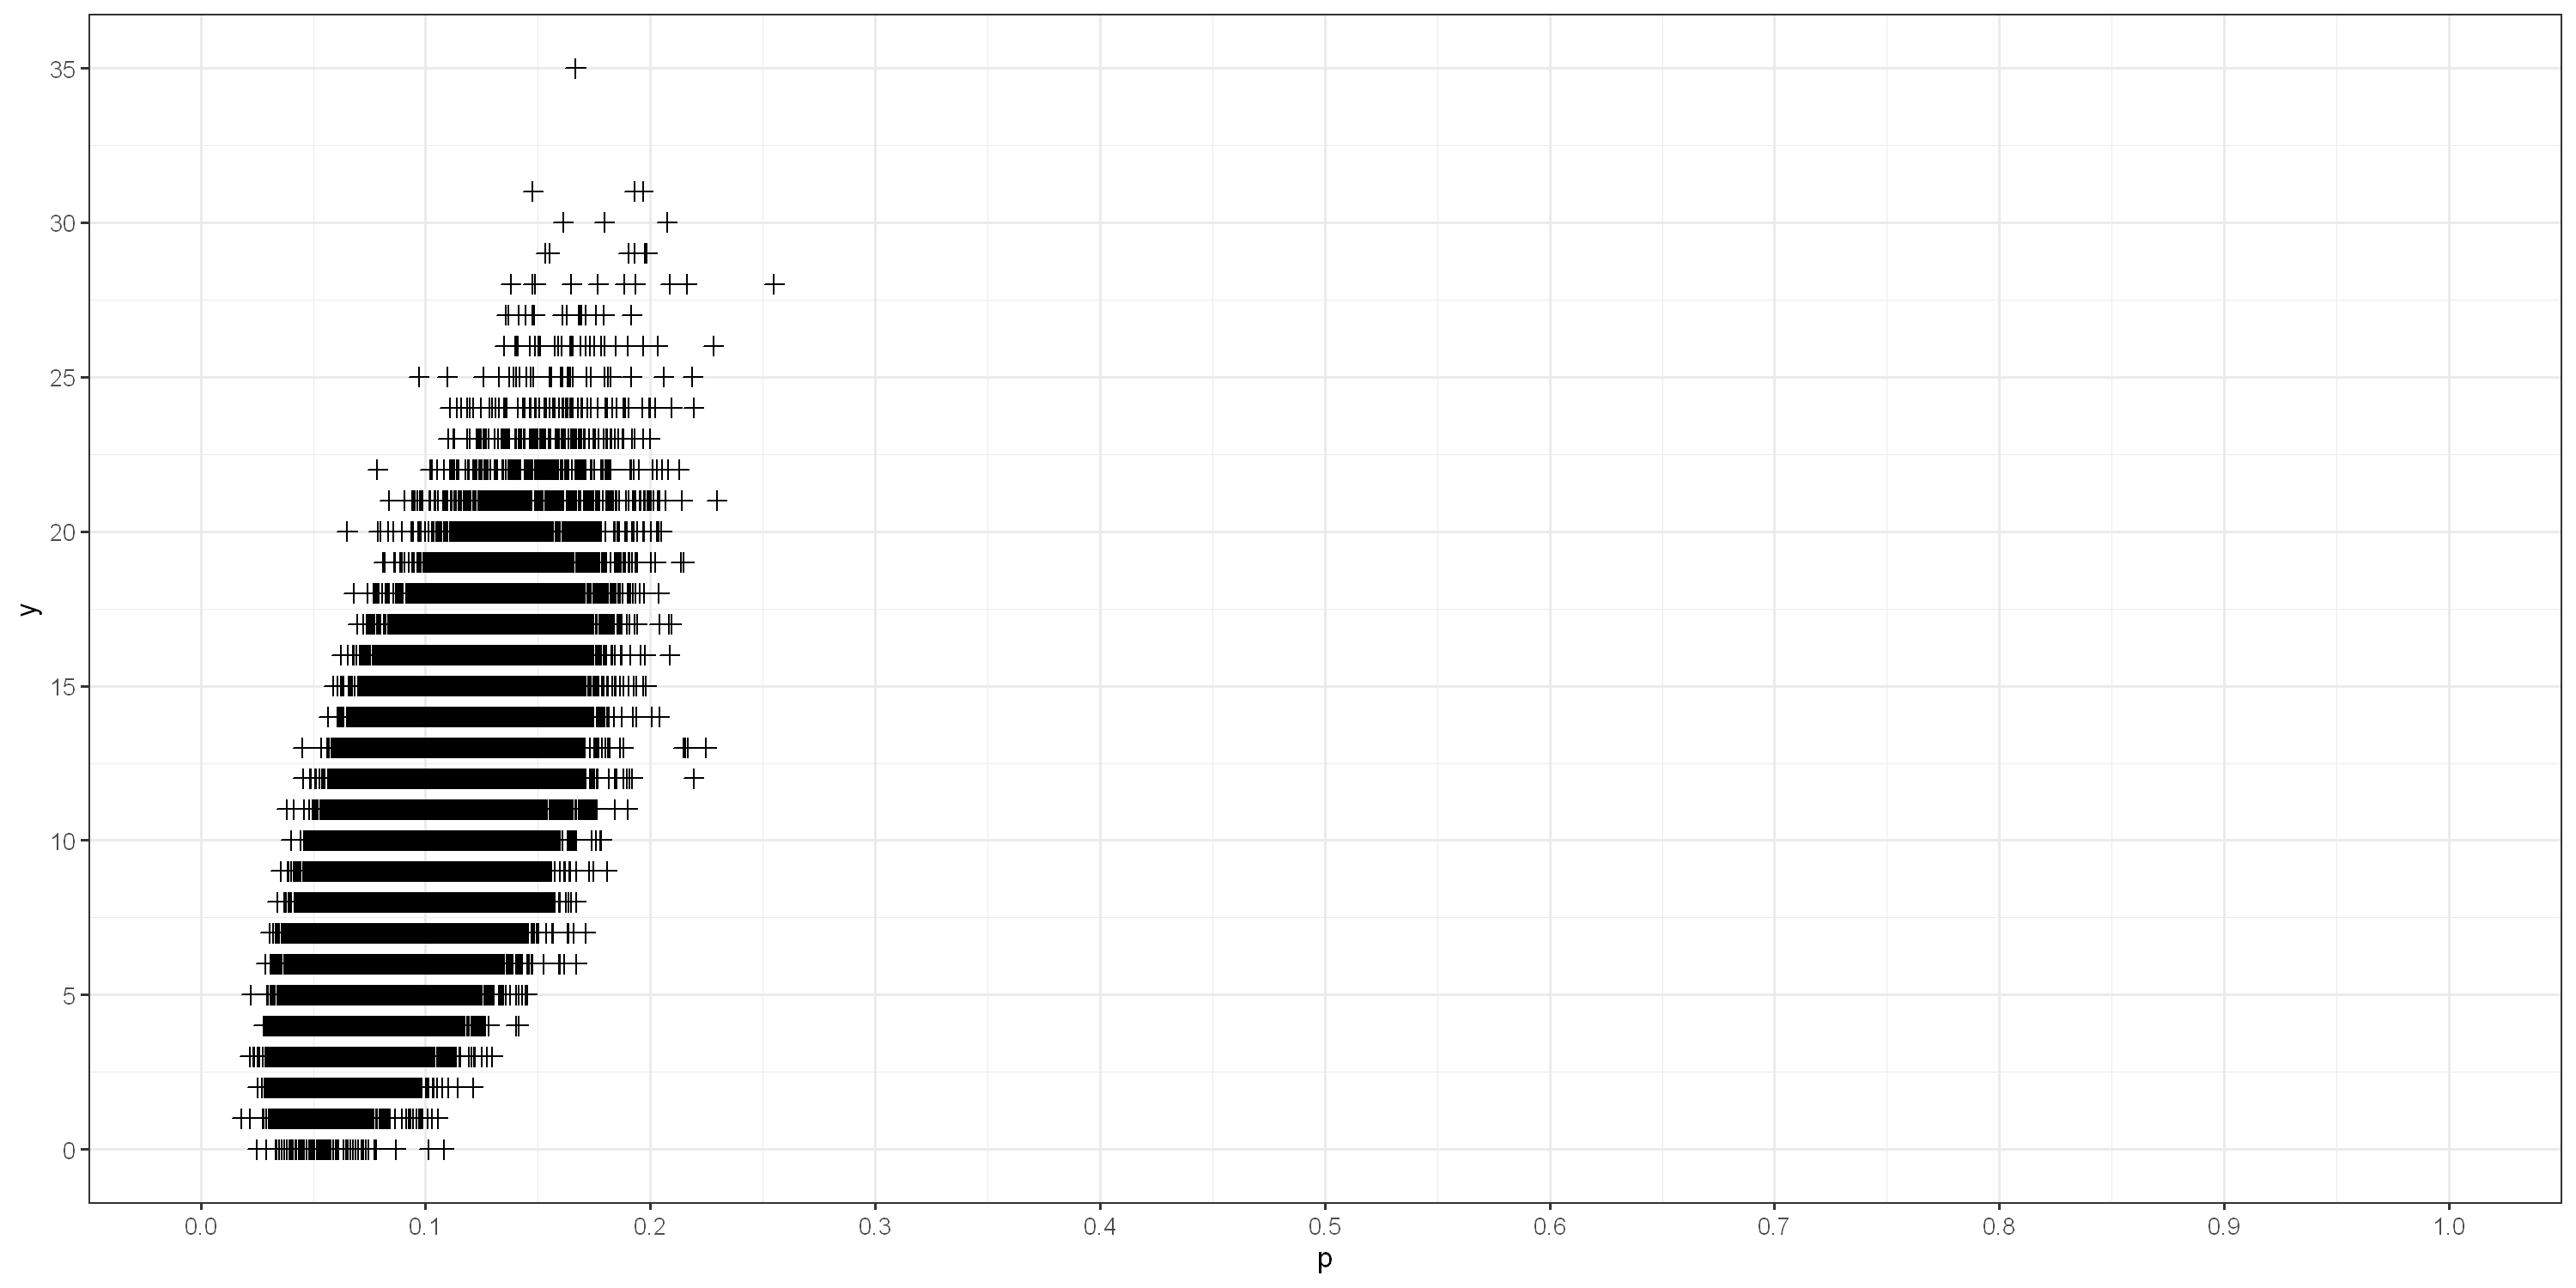

In [53]:
# correlation plot
results$corr_plot